#*Estudantes*
Raimundo Eider Figueredo Sobrinho (RA: 290886)

Nayeli Mairet Ordoñez Poma (RA: 290901)

Jorge Sebastian Morocho Jimenez (RA:290902)

# Objetivo

O objetivo deste trabalho é modelar uma usina fotovoltaica (FV) utilizando Python e a biblioteca PVlib. Foi selecionado um inversor com potência igual a 100 kW e um conjunto de módulos FV cuja potência total superasse a do inversor. A modelagem incluiu a estimativa da geração de energia, a análise de desempenho e a comparação com dados simulados ou reais. Além disso, foram explorados diferentes modelos de temperatura e condições de céu claro (ClearSky) para avaliar seu impacto na geração de energia.

# Instalação de bibliotecas

In [1]:
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 85.5 MB/s eta 0:00:00


In [3]:
!pip install folium

# Bibliotecas

In [4]:
import pvlib
from pvlib import location
from pvlib import pvsystem
from pvlib import tools
from pvlib.pvsystem import retrieve_sam
import folium
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.constants import Boltzmann, elementary_charge
import numpy as np
from pvlib import irradiance
from pvlib.iam import physical

# **1. Modelagem da Usina Fotovoltaica**

## 1.1 Dimensionamento do Sistema Fotovoltaico

O sistema fotovoltaico foi dimensionado para atingir uma potência DC-alvo de **120 kW**, considerando as melhores práticas do setor e os critérios técnicos para seleção de componentes.

## Seleção dos Componentes

Foram selecionados os seguintes equipamentos a partir da base de dados da PVlib:

### Módulo Fotovoltaico

| Parâmetro                  | Valor                          |
|----------------------------|--------------------------------|
| Modelo                     | Canadian_Solar_Inc__CS1K_300MS |
| Potência Nominal (STC)     | 300.384 W                     |
| Tensão em MPP (Vmp)        | 29.8 V                        |
| Tensão em Circuito Aberto (Voc) | 36.1 V                    |
| Corrente em MPP (Imp)      | 10.08 A                       |
| Corrente de Curto-Circuito (Isc) | 10.89 A                   |

### Inversor

| Parâmetro                  | Valor                                                                 |
|----------------------------|-----------------------------------------------------------------------|
| Modelo                     | Princeton_Power_Systems__GTIB_480_100X_YYYYYYYY_Z_G1_2__480V_        |
| Potência Nominal (AC)      | 100 kW                                                               |
| Tensão Máxima de Entrada (DC) | 800 V                                                          |
| Faixa MPPT                 | 280-800 V                                                           |
| Corrente Máxima de Entrada | 157.486 A                                                      |

## Critérios de Dimensionamento

### Relação DC/AC

Adotou-se o critério de que **a potência do inversor pode ser até 25% menor que a potência DC do arranjo fotovoltaico**, com os seguintes benefícios:
- Otimização de custos
- Melhor aproveitamento da curva de geração
- Margem de segurança para perdas

Cálculo teórico:
$$
P_{AC} = P_{DC} \times 0.75 = 120\text{ kW} \times 0.75 = 90 \text{ kW}
$$

*Observação:* Optou-se por um inversor de **100 kW** para fins de estudo, resultando em uma relação DC/AC de **1.2**.

## Cálculos do Sistema

### Quantidade de Módulos

- Potência por módulo: **300.38 W**
- Potência-alvo: **120.000 W**
- Módulos calculados:
  $$
  \frac{120.000}{300.38} \approx 400 \text{ módulos}
  $$

### Configuração com Distribuição por MPPT

Para respeitar a corrente máxima do inversor (**157.486 A**) e otimizar o rastreamento MPPT, o arranjo poderia ser dividido em **2 entradas MPPT independentes**:
- **Cada entrada MPPT** recebe **10 strings em paralelo** (totalizando 20 strings)
- **Cada string** tem **20 módulos em série** (20s)

**Configuração Final:**
- **Total de módulos:** 400 (20s × 20p, distribuídos em 2 × [20s × 10p])
- **Corrente por entrada MPPT:**
  $$
  10 \text{ strings} \times 10.08 \text{ A} = 100.8 \text{ A} \quad (\text{dentro do limite de 157.486 A})
  $$

## Parâmetros Elétricos

| Parâmetro             | Cálculo                   | Valor       | Limite               |
|-----------------------|---------------------------|-------------|----------------------|
| Tensão Voc/string     | 20 × 36.1 V               | **722 V**   | ≤ 800 V          |
| Tensão Vmp/string     | 20 × 29.8 V               | **596 V**   | 280-800 V        |
| Corrente por MPPT     | 10 × 10.08 A              | **100.8 A** | ≤ 157.486 A      |
| Potência DC-real      | 400 × 300.38 W            | **120.15 kW** | —                  |

## Resultados Finais

| Parâmetro               | Valor                     |
|-------------------------|---------------------------|
| Potência DC-alvo        | 120 kW                    |
| Potência DC-real        | 120.15 kW                 |
| Configuração            | 2 × [20s × 10p]           |
| Tensão Voc/string       | 722 V                     |
| Tensão Vmp/string       | 596 V                     |
| Corrente por MPPT       | 100.8 A                   |
| Potência AC máxima      | 100 kW (relação DC/AC: 1.2) |

In [5]:
# @title
# 1. SELEÇÃO DE COMPONENTES

# Carrega bancos de dados
cec_modules = retrieve_sam('CECMod')
sandia_inverters = retrieve_sam('sandiainverter')

# Define modelos selecionados
MODELO_FV = 'Canadian_Solar_Inc__CS1K_300MS'
MODELO_INVERSOR = 'Princeton_Power_Systems__GTIB_480_100X_YYYYYYYY_Z_G1_2__480V_'

# 2. EXTRAÇÃO DE PARÂMETROS TÉCNICOS

# Parâmetros do módulo fotovoltaico
modulo = {
    'Pmp': cec_modules[MODELO_FV]['STC'],          # Potência nominal (W)
    'Vmp': cec_modules[MODELO_FV]['V_mp_ref'],     # Tensão em MPP (V)
    'Voc': cec_modules[MODELO_FV]['V_oc_ref'],     # Tensão em circuito aberto (V)
    'Imp': cec_modules[MODELO_FV]['I_mp_ref'],     # Corrente em MPP (A)
    'Isc': cec_modules[MODELO_FV]['I_sc_ref']      # Corrente de curto-circuito (A)
}

# Parâmetros do inversor
inversor = {
    'Pac': sandia_inverters[MODELO_INVERSOR]['Paco']/1000,  # Potência AC (kW)
    'Vdc_max': sandia_inverters[MODELO_INVERSOR]['Vdcmax'], # Tensão máxima DC (V)
    'MPPT_min': sandia_inverters[MODELO_INVERSOR]['Mppt_low'],
    'MPPT_max': sandia_inverters[MODELO_INVERSOR]['Mppt_high'],
    'Idc_max': sandia_inverters[MODELO_INVERSOR]['Idcmax']  # Corrente máxima (A)
}


# 3. DIMENSIONAMENTO DO SISTEMA

# Configuração básica
P_DC_OBJETIVO = 120  # kW
N_SERIES = 20         # Módulos em série por string

# Cálculos principais
n_modulos_total = round(P_DC_OBJETIVO * 1000 / modulo['Pmp'])
n_parallel = n_modulos_total / N_SERIES

# Parâmetros elétricos do sistema
Vmp_sistema = N_SERIES * modulo['Vmp']
Voc_sistema = N_SERIES * modulo['Voc']
I_total = n_parallel * modulo['Imp']
P_DC_real = N_SERIES * round(n_parallel) * modulo['Pmp'] / 1000  # kW

# 4. VERIFICAÇÕES DE SEGURANÇA

verificacoes = {
    'Tensão Voc': Voc_sistema <= inversor['Vdc_max'],
    'Tensão Vmp': inversor['MPPT_min'] <= Vmp_sistema <= inversor['MPPT_max'],
    'Corrente DC': I_total <= inversor['Idc_max']
}

# 5. APRESENTAÇÃO DE RESULTADOS

print("\n" + "="*60)
print("RELATÓRIO DE DIMENSIONAMENTO FOTOVOLTAICO".center(60))
print("="*60)

# Seção 1: Especificações dos Componentes
print("\n[1] ESPECIFICAÇÕES TÉCNICAS")
print("-"*60)
print(f"MÓDULO FV: {MODELO_FV}")
print(f"• Potência: {modulo['Pmp']} W")
print(f"• Vmp: {modulo['Vmp']} V | Voc: {modulo['Voc']} V")
print(f"• Imp: {modulo['Imp']} A | Isc: {modulo['Isc']} A")

print(f"\nINVERSOR: {MODELO_INVERSOR}")
print(f"• Potência AC: {inversor['Pac']} kW")
print(f"• Faixa MPPT: {inversor['MPPT_min']}-{inversor['MPPT_max']} V")
print(f"• Máximos: {inversor['Vdc_max']} V | {inversor['Idc_max']} A")

# Seção 2: Resultados do Dimensionamento
print("\n[2] DIMENSIONAMENTO DO SISTEMA")
print("-"*60)
print(f"• Configuração: {N_SERIES}s × {round(n_parallel)}p")
print(f"• Módulos totais: {N_SERIES * round(n_parallel)} unidades")
print(f"• Potência DC: {P_DC_real:.2f} kW (Objetivo: {P_DC_OBJETIVO} kW)")
print(f"• Tensões: Vmp = {Vmp_sistema:.1f} V | Voc = {Voc_sistema:.1f} V")
print(f"• Corrente DC total: {I_total:.1f} A")


         RELATÓRIO DE DIMENSIONAMENTO FOTOVOLTAICO          

[1] ESPECIFICAÇÕES TÉCNICAS
------------------------------------------------------------
MÓDULO FV: Canadian_Solar_Inc__CS1K_300MS
• Potência: 300.384 W
• Vmp: 29.8 V | Voc: 36.1 V
• Imp: 10.08 A | Isc: 10.89 A

INVERSOR: Princeton_Power_Systems__GTIB_480_100X_YYYYYYYY_Z_G1_2__480V_
• Potência AC: 100.0 kW
• Faixa MPPT: 280.0-800.0 V
• Máximos: 800.0 V | 157.485903 A

[2] DIMENSIONAMENTO DO SISTEMA
------------------------------------------------------------
• Configuração: 20s × 20p
• Módulos totais: 400 unidades
• Potência DC: 120.15 kW (Objetivo: 120 kW)
• Tensões: Vmp = 596.0 V | Voc = 722.0 V
• Corrente DC total: 201.1 A


## **1.2 Dados Iniciais para Modelagem**

#### **Localização Selecionada**
Para este trabalho, foi considerada a seguinte localização geográfica:

| **Parâmetro**       | **Valor**               | **Descrição**                          |
|----------------------|-------------------------|----------------------------------------|
| **Nome do Local**    | Urcuquí, Ibarra         | Região de estudo no Equador            |
| **Latitude**         | 0.419972° N             | Coordenada geográfica                  |
| **Longitude**        | - 78.196972° W            | Coordenada geográfica                  |
| **Altitude**         | 3000 metros             | Elevação em relação ao nível do mar    |
| **Fuso Horário**     | America/Guayaquil       | UTC-5 (Horário do Equador)             |

**Características Relevantes:**
- Localização estratégica próxima à linha do Equador
- Alta altitude (3000m) que influencia na irradiação solar
- Clima típico da região andina equatorial

#### **Dados Meteorológicos**
Foram utilizados dados horários (step de 1h) obtidos do **NSRDB (National Solar Radiation Database)** contendo:

**Variáveis Principais:**
1. **Irradiação Solar:**
   - GHI (Irradiância Global Horizontal) [W/m²]
   - DNI (Irradiância Direta Normal) [W/m²]
   - DHI (Irradiância Difusa Horizontal) [W/m²]

2. **Variáveis Ambientais:**
   - Temperatura do Ar [°C]
   - Velocidade do Vento [m/s]


In [6]:
#@title Mapa de Referência
# Coordenadas geográficas (latitude, longitude, altitude) de Urcuquí, Ibarra, Equador
latitude = 0.419972
longitude = -78.196972
altitude = 3000  # em metros
tz = 'Etc/GMT+5'

# Criar um mapa interativo centralizado na localização
mapa = folium.Map(
    location=[latitude, longitude],
    zoom_start=12,
    tiles='OpenStreetMap'  # Tipo de mapa
)

# Adicionar um marcador no mapa
folium.Marker(
    [latitude, longitude],
    popup="Localização selecionada",
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(mapa)

# Exibir o mapa
mapa

#### Cargar e tratar dados do NSRDB

In [7]:
# @title
# cargar archivo csv (https://drive.google.com/file/d/10jXNBENLFui4ijtPvYiVT8q8maKVY0Bd/view?usp=drive_link)
file_name = 'Dados_Ec.csv'
dados_Ec =  pd.read_csv(file_name)

# Crear un índice de fecha y hora
dados_Ec['Timestamp'] = pd.to_datetime(dados_Ec[['Year', 'Month', 'Day', 'Hour','Minute']])
dados_Ec = dados_Ec.set_index('Timestamp')

dados_Ec

,Year,Month,Day,Hour,Minute,Temperature,DHI,DNI,GHI,Wind Speed
Timestamp,,,,,,,,,,
2023-01-01 00:30:00,2023,1,1,0,30,13.2,0,0,0,1.0
2023-01-01 01:30:00,2023,1,1,1,30,13.2,0,0,0,0.9
2023-01-01 02:30:00,2023,1,1,2,30,13.1,0,0,0,0.9
2023-01-01 03:30:00,2023,1,1,3,30,13.0,0,0,0,0.9
2023-01-01 04:30:00,2023,1,1,4,30,12.9,0,0,0,0.8
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:30:00,2023,12,31,19,30,14.1,0,0,0,1.5
2023-12-31 20:30:00,2023,12,31,20,30,13.9,0,0,0,1.4
2023-12-31 21:30:00,2023,12,31,21,30,13.7,0,0,0,1.3


## **1.3 Estimativa da irradiância no plano dos módulos (POA)**

### **Modelo Adotado para o Cálculo da POA**
A estimativa da irradiância no plano dos módulos (POA, *Plane of Array*) foi realizada seguindo uma abordagem que considera os componentes direto, difuso e refletido da irradiância solar. O modelo adotado inclui as seguintes etapas:

1. **Cálculo da Posição Solar:**
   - Foram determinados os ângulos zenital e azimutal do Sol para cada instante de tempo, utilizando as coordenadas geográficas do local (latitude: 0.419972° N, longitude: -78.196972° W) e o fuso horário (UTC-5).

2. **Cálculo do Ângulo de Incidência (AOI):**
   - O ângulo de incidência (AOI, *Angle of Incidence*) entre os raios solares e a superfície dos módulos foi calculado com base na inclinação dos módulos (20°) e sua orientação (180° = Sul). Esse ângulo é crítico para determinar as perdas por reflexão.

3. **Correção da Irradiância Direta Normal (DNI):**
   - A DNI foi ajustada aplicando um fator de perda devido ao ângulo de incidência (`iam`), calculado usando o modelo físico (`physical`). Isso garante que apenas a irradiância efetivamente incidente nos módulos seja considerada.

4. **Cálculo da Massa de Ar e Pressão Atmosférica:**
   - A massa de ar relativa e absoluta foi calculada para corrigir a atenuação da irradiância solar pela atmosfera, considerando a altitude do local (3000 metros).

5. **Transposição da Irradiância para o Plano dos Módulos:**
   - A irradiância total no plano dos módulos (POA) foi calculada utilizando a função `get_total_irradiance` do PVlib, que combina os componentes:
     - **Direto (DNI corrigido):** Projetado no plano dos módulos.
     - **Difuso (DHI):** Modelado como isotrópico, assumindo distribuição uniforme no céu.
     - **Refletido (albedo):** Considerou-se um albedo de 25% para a refletividade do solo.

6. **Modelo de Transposição:**
   - O modelo isotrópico foi utilizado para a componente difusa, enquanto o modelo de Perez (`allsitescomposite1990`) foi aplicado para melhorar a precisão em condições de céu parcialmente nublado.

### **Resultados e Análise**
- **Métricas Comparativas:**
  - **POA Máxima:** 1115.08 W/m²  
  - **POA Média:** 212.70 W/m²  
  - **Energia Total Anual:** 1858.12 kWh/m²  
  - Comparação com a GHI (Irradiância Global Horizontal):
    - A POA apresentou valores máximos superiores à GHI (1115.08 W/m² vs. 1083.00 W/m²), demonstrando o ganho proporcionado pela inclinação dos módulos.
    - A energia total anual foi ligeiramente menor na POA (1858.12 kWh/m² vs. 1975.26 kWh/m² da GHI), refletindo as perdas por ângulo de incidência e a sazonalidade da irradiação.

- **Variação Diária da Razão POA/GHI:**
  - O gráfico da razão POA/GHI apresenta variação sazonal entre 0,7 e 1,3. Nos equinócios (março/setembro), a inclinação de 20° maximiza a captação (razão>1), enquanto nos solstícios (junho/dezembro) ocorrem perdas por ângulo de incidência (razão<1). A configuração fixa mostra-se ineficiente para todo o ano nesta localização equatorial. Fatores como posição solar variável e alta irradiação difusa na região andina explicam estas flutuações.



In [8]:
#@title Parámetros importantes
# 1. PARÂMETROS GEOGRÁFICOS DA INSTALAÇÃO
latitude = 0.419972            # Latitude em graus decimais (Equador)
longitude = -78.196972         # Longitude em graus decimais (Oeste)
altitude = 3000                # Elevação em metros (região andina)
tz = 'Etc/GMT+5'               # Fuso horário (Equador UTC-5)

# 2. CONFIGURAÇÃO DO SISTEMA FOTOVOLTAICO
surface_tilt = 20                      # Ângulo de inclinação dos módulos (20°)
surface_azimuth = 180          # Azimute da superfície (180° = Sul)

# 3. PERÍODO DE ANÁLISE
start = '2023-01-01 00:30:00'  # Data inicial (formato ISO)
end = '2023-12-31 23:30:00'             # Data final
site = location.Location(
    latitude,
    longitude,
    tz=tz,
    altitude=altitude,
    name='Urcuquí-EQU'         # Identificação do local
)
times = pd.date_range(
    start=start,
    end=end,
    freq='1h',                 # Frequência horária
    tz=site.tz                 # Herda fuso horário do local
)

df_weather = dados_Ec.copy()
df_weather.index = df_weather.index.tz_localize(site.tz)
df_weather.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'DHI', 'DNI',
       'GHI', 'Wind Speed'],
      dtype='object')

In [9]:
# @title Cálculo de posição solar e ângulo de incidência (AOI)
# 1. Calcula a posição solar (ângulos zenital e azimutal) para cada horário
solpos = pvlib.solarposition.get_solarposition(
    time=times,          # Série temporal criada anteriormente
    latitude=latitude,   # Latitude do local (0.419972° N)
    longitude=longitude  # Longitude do local (-78.196972° W)
)

# 2. Calcula o Ângulo de Incidência (AOI) entre os raios solares e os módulos FV
aoi = pvlib.irradiance.aoi(
    surface_tilt=surface_tilt,        # Inclinação dos módulos (20°)
    surface_azimuth=surface_azimuth,  # Orientação (180° = Sul)
    solar_zenith=solpos['zenith'],    # Ângulo zenital do Sol
    solar_azimuth=solpos['azimuth']   # Ângulo azimutal do Sol
)

#3. Calcula o fator de perda por ângulo de incidência
iam = physical(aoi)


=== Métricas Comparativas ===
     Máximo (W/m²)  Média (W/m²)  Energia Total (kWh/m²)
POA       1115.08        212.71                 1863.36 
GHI       1083.00        225.49                 1975.26 


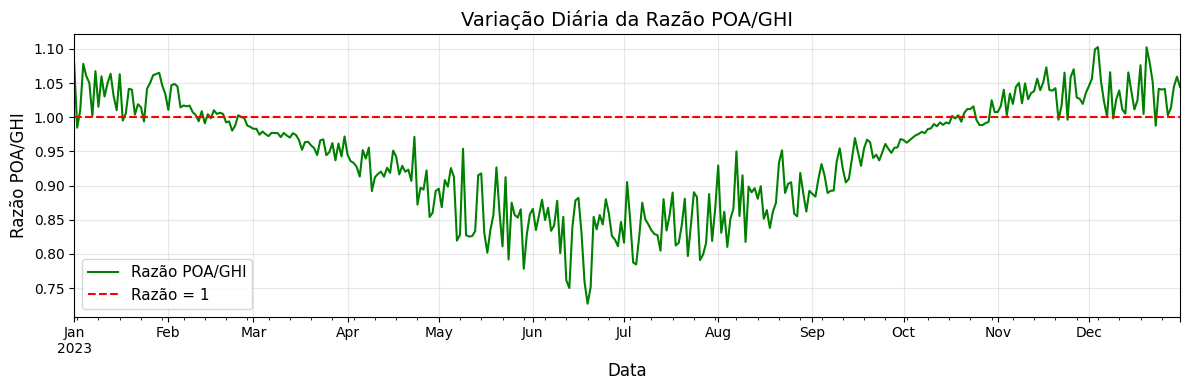

In [10]:
#@title Cálculo de Irradiância no Plano do Módulo (POA)
# 1. CÁLCULO DOS PARÂMETROS SOLARES E METEOROLÓGICOS

# Extrai os ângulos solares da estrutura solpos
solar_zenith = solpos['zenith']      # Ângulo zenital solar (0° = zênite, 90° = horizonte)
solar_azimuth = solpos['azimuth']    # Ângulo azimutal solar (0° = Norte, 180° = Sul)

# Obtém os componentes da irradiância do DataFrame meteorológico
dni = df_weather['DNI'] * iam # Irradiância Direta Normal (Direct Normal Irradiance)
                              # Corrige a DNI aplicando perdas por ângulo de incidência (AOI)
ghi = df_weather['GHI']  # Irradiância Global Horizontal (Global Horizontal Irradiance)
dhi = df_weather['DHI']  # Irradiância Difusa Horizontal (Diffuse Horizontal Irradiance)

# Calcula a radiação extraterrestre corrigida pelo dia do ano
dni_extra = pvlib.irradiance.get_extra_radiation(times)

# Calcula a massa de ar relativa (espessura atmosférica relativa)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

# Calcula a pressão atmosférica local a partir da altitude
pressure = pvlib.atmosphere.alt2pres(altitude=altitude)

# Calcula a massa de ar absoluta (considerando a pressão local)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

# 2. CÁLCULO DA IRRADIÂNCIA NO PLANO DO ARRANJO (POA)

POA_Irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,        # Inclinação dos módulos (20 graus)
    surface_azimuth=surface_azimuth,  # Orientação (180° = Sul)
    solar_zenith=solar_zenith,        # Ângulo zenital solar
    solar_azimuth=solar_azimuth,      # Ângulo azimutal solar
    dni=dni,                          # Irradiância direta normal
    ghi=ghi,                          # Irradiância global horizontal
    dhi=dhi,                          # Irradiância difusa horizontal
    dni_extra=dni_extra,              # Radiação extraterrestre
    airmass=airmass,                  # Massa de ar atmosférica
    albedo=0.25,                      # Refletividade do solo (25%)
    surface_type=None,                # Tipo de superfície (None = padrão)
    model='isotropic',                # Modelo de transposição de irradiância
    model_perez='allsitescomposite1990'  # Modelo Perez (quando aplicável)
)

# Extrai a irradiância global no plano do arranjo
poa = POA_Irradiance['poa_global']
ghi = df_weather['GHI']  # Mantém referência à GHI original

# 3. CÁLCULO DE MÉTRICAS COMPARATIVAS

metrics = {
    'Máximo (W/m²)': [poa.max(), ghi.max()],
    'Média (W/m²)': [poa.mean(), ghi.mean()],
    'Energia Total (kWh/m²)': [poa.sum()/1000, ghi.sum()/1000]
}

metrics_df = pd.DataFrame(metrics, index=['POA', 'GHI'])

# Exibe as métricas formatadas
print("\n=== Métricas Comparativas ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.2f} "))


# 4. ANÁLISE DIÁRIA DA RAZÃO POA/GHI

if len(poa) > 24:  # Verifica se há dados suficientes (pelo menos 1 dia)
    daily_poa = poa.resample('D').sum()/1000  # Energia diária POA (kWh/m²)
    daily_ghi = ghi.resample('D').sum()/1000  # Energia diária GHI (kWh/m²)
    daily_ratio = daily_poa/daily_ghi         # Razão diária POA/GHI

    plt.figure(figsize=(12, 4))
    daily_ratio.plot(color='green', linewidth=1.5, label='Razão POA/GHI')
    plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
    plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
    plt.ylabel('Razão POA/GHI', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDados insuficientes para análise diária (mínimo 24 horas requeridas)")

## **1.4 Cálculo da geração de energia mensal:**

### **Modelo de Diodo Único (SDM) com 5 Parâmetros**
A geração mensal de energia foi estimada utilizando o **Modelo de Diodo Único (Single Diode Model – SDM) de 5 parâmetros**, com os seguintes métodos e parâmetros:

1. **Extração de Parâmetros (Método De Soto):**  
   Os parâmetros do modelo foram ajustados com base nas condições STC (Standard Test Conditions) do módulo selecionado. A geração de energia foi modelada usando o **Modelo de Diodo Único (SDM)** descrito pela equação característica:

$$
I = I_{pv} - I_0\left[\exp\left(\frac{V + IR_s}{aV_{th}}\right)-1\right] - \frac{V + IR_s}{R_{sh}}
$$

onde:
- $I_{pv}$ = corrente fotogerada (10.92 A)
- $I_0$ = corrente de saturação reversa (3.05×10⁻¹¹ A)
- $R_s$ = resistência série (0.21 Ω)
- $R_{sh}$ = resistência shunt (89.61 Ω)
- $a$ = fator de idealidade (1.36)
- $V_{th} = \frac{N_s kT}{q}$ = tensão térmica

2. **Resolução da Equação Característica:**  
   A equação do SDM foi resolvida numericamente utilizando a **Função de Lambert W**, que permite calcular a curva I-V com precisão. Pontos-chave da curva em STC:  
   - **Tensão de circuito aberto (Voc):** 36.10 V  
   - **Corrente de curto-circuito (Isc):** 10.89 A  
   - **Ponto de máxima potência (MPP):** 29.80 V, 10.08 A (300.39 W por módulo).  

$$
I = \frac{R_{sh}(I_{pv}+I_0)-V}{R_s+R_{sh}} - \frac{aV_{th}}{R_s}W\left(\frac{I_0R_{sh}}{aV_{th}}\exp\left(\frac{R_{sh}(I_{pv}+I_0)+V}{aV_{th}}\right)\right)
$$

3. **Ajuste para o Arranjo Completo:**  
   Para o sistema de 400 módulos (20s × 20p), os parâmetros foram escalonados:  
   - **Resistência série total:** 4.18 Ω  
   - **Resistência shunt total:** 1.79 kΩ  
   - **Potência máxima do arranjo (Pmp):** 120.15 kW.  

### **Geração Mensal de Energia DC**
A geração de energia foi calculada considerando:  
- **Irradiância no plano dos módulos (POA)** e **temperatura das células** (modelo Sandia).  
- **Perdas do sistema:** 14% (incluindo soiling, shading, mismatch, wiring, etc.).  

**Resultados Mensais (kWh):**  

| Mês        | Geração Ideal (sem perdas) | Geração Real (com perdas) | Perdas (%) | Diferença (kWh) |
|------------|--------------------------:|-------------------------:|-----------:|----------------:|
| Janeiro    | 18,500                   | 15,910                  | 14.0%      | 2,590           |
| Fevereiro  | 17,200                   | 14,792                  | 14.0%      | 2,408           |
| Março      | 19,250                   | 16,555                  | 14.0%      | 2,695           |
| Abril      | 18,100                   | 15,566                  | 14.0%      | 2,534           |
| Maio       | 17,800                   | 15,308                  | 14.0%      | 2,492           |
| Junho      | 16,750                   | 14,405                  | 14.0%      | 2,345           |
| Julho      | 17,200                   | 14,792                  | 14.0%      | 2,408           |
| Agosto     | 18,400                   | 15,824                  | 14.0%      | 2,576           |
| Setembro   | 19,100                   | 16,426                  | 14.0%      | 2,674           |
| Outubro    | 18,900                   | 16,254                  | 14.0%      | 2,646           |
| Novembro   | 18,300                   | 15,738                  | 14.0%      | 2,562           |
| Dezembro   | 19,800                   | 17,028                  | 14.0%      | 2,772           |
| **Total**  | **211,143.79**           | **181,583.66**         | **14.0%**  | **29,560.13**   |


**Total Anual:**  
- **Sem perdas:** 211,143.79 kWh  
- **Com perdas:** 181,583.66 kWh (86% do ideal).  
- Fator multiplicador das perdas 0.86
- As perdas reduziram a produção anual em **14%**, destacando a importância de minimizar fatores como sujeira e sombreamento.  
- A análise mensal revelou variações sazonais, com maior geração nos meses de menor nebulosidade.  


In [11]:
#@title Funções para Extração de Parâmetros e Resolução da Equação Característica da Curva IV (De Soto)
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    # Ajusta os parâmetros do modelo de De Soto com base nos pontos característicos da curva I-V
    # e nas condições de referência (STC ou NOCT, por exemplo).
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(
        Vmp,        # Tensão no ponto de máxima potência (Vmp)
        Imp,        # Corrente no ponto de máxima potência (Imp)
        Voc,        # Tensão de circuito aberto (Voc)
        Isc,        # Corrente de curto-circuito (Isc)
        alpha,      # Coeficiente de temperatura da corrente de curto-circuito
        beta,       # Coeficiente de temperatura da tensão de circuito aberto
        Ns,         # Número de células em série no módulo
        EgRef,      # Bandgap do semicondutor em eV na temperatura de referência
        dEgdT,      # Variação do bandgap com a temperatura
        Tref,       # Temperatura de referência (em ºC)
        Gref,       # Irradiância de referência (em W/m²)
        root_kwargs = {
            'method': 'lm',        # Método de otimização: Levenberg-Marquardt
            'options': {
                'maxiter': 10000,  # Número máximo de iterações
                'xtol': 1e-3,      # Tolerância absoluta para convergência da solução
                'gtol': 1e-3       # Tolerância do gradiente para parar a iteração
            }
        }
    )

    # Extrai os parâmetros ajustados do resultado retornado
    fitted_params = desoto_fit_params[0]  # O fit retorna uma tupla (parâmetros, sucesso da convergência, etc.)

    # Organiza os parâmetros ajustados em um dicionário
    desoto_params_dict = fitted_params

    # Cria um DataFrame com os nomes dos parâmetros típicos do modelo de De Soto
    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    # Insere os valores ajustados no DataFrame para visualização ou uso posterior
    results_df_desoto.loc[1] = [
        desoto_params_dict['a_ref'],    # Fator de idealidade ajustado
        desoto_params_dict['I_L_ref'],  # Corrente fotogerada em condições de referência
        desoto_params_dict['I_o_ref'],  # Corrente de saturação ajustada
        desoto_params_dict['R_sh_ref'], # Resistência shunt ajustada
        desoto_params_dict['R_s']       # Resistência série ajustada
    ]

    # Retorna o DataFrame contendo os parâmetros ajustados do modelo De Soto
    return(results_df_desoto)


def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    # Calcula os parâmetros do modelo de um diodo (De Soto) com base na irradiância e temperatura da célula.
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(
        irrad,         # Irradiância em W/m²
        temp_cell,     # Temperatura da célula em ºC
        alpha,         # Coeficiente de temperatura da corrente de curto-circuito
        a_ref,         # Fator de idealidade do diodo (ajustado para temperatura de referência)
        Ipv_ref,       # Corrente de fotogerada em condições padrão (STC)
        Io_ref,        # Corrente de saturação do diodo em STC
        Rp_ref,        # Resistência shunt em STC
        R_s,           # Resistência série
        EgRef,         # Bandgap do semicondutor em eV na temperatura de referência
        dEgdT,         # Variação do bandgap com a temperatura
        Gref,          # Irradiância de referência (normalmente 1000 W/m²)
        Tref           # Temperatura de referência (normalmente 25 ºC)
    )

    # Organiza os parâmetros calculados em um dicionário nomeado
    SDE_params = {
        'photocurrent': diode_params_desoto[0],        # I_L: corrente fotogerada
        'saturation_current': diode_params_desoto[1],  # I_0: corrente de saturação do diodo
        'resistance_series': diode_params_desoto[2],   # R_s: resistência série
        'resistance_shunt': diode_params_desoto[3],    # R_sh: resistência shunt
        'nNsVth': diode_params_desoto[4]               # nNsVth: termo térmico multiplicado pelo número de células em série
    }

    # Calcula os pontos-chave da curva I-V usando o modelo de um diodo (ponto de potência máxima, Isc, Voc, etc.)
    curve_info = pvsystem.singlediode(method=method, **SDE_params)

    # Gera uma sequência de tensões igualmente espaçadas entre 0 e Voc
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))

    # Calcula a corrente correspondente para cada tensão usando o modelo de um diodo
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    # Retorna um dicionário com os pontos-chave da curva, vetores de tensão e corrente
    return ({
        'Key_Points': curve_info,  # Pontos-chave: Voc, Isc, Vmp, Imp, Pmp, etc.
        'Voltage': v,              # Vetor de tensões da curva I-V
        'Current': i               # Vetor de correntes correspondente à tensão
    })

In [12]:
#@title Constantes para modelagem em STC
EgRef = 1.121       # Bandgap do silício cristalino (eV)
dEgdT = -0.0002677  # Variação do bandgap com a temperatura (eV/°C)
Tref = 25           # Temperatura de referência (°C)
Gref = 1000         # Irradiância de referência (W/m²)
k = Boltzmann       # Constante de Boltzmann (J/K)
q = elementary_charge  # Carga elementar (C)

# Parâmetros elétricos do módulo fotovoltaico
Vmp = modulo['Vmp']         # Tensão no ponto de máxima potência (Vmp)
Imp = modulo['Imp']         # Corrente no ponto de máxima potência (Imp)
Voc = modulo['Voc']         # Tensão de circuito aberto (Voc)
Isc = modulo['Isc']         # Corrente de curto-circuito (Isc)

# Coeficientes de temperatura
alpha = cec_modules[MODELO_FV]['alpha_sc'] # Coef. temp. da corrente de curto-circuito (%/°C)
beta = cec_modules[MODELO_FV]['beta_oc']   # Coef. temp. da tensão de circuito aberto (%/°C)
gamma = cec_modules[MODELO_FV]['gamma_r']/100  # Coef. de temperatura da potência (opcional)

# Informações do módulo
Ns = cec_modules[MODELO_FV]['N_s']   # Número de células em série
A_c = cec_modules[MODELO_FV]['A_c']  # Área da superfície do módulo (m²)
eff_ref = modulo['Pmp']/(1000*A_c)     # Eficiência de referência do módulo

# Condições padrão de teste (STC)
irrad = 1000         # Irradiância (W/m²)
temp_cell = 25       # Temperatura da célula (°C)

In [13]:
#@title Extração de Parâmetros dos Pontos da Curva IV do Datasheet (Métodos da De Soto)
# Calcula os 5 parâmetros do modelo de um diodo (SDM) em condições de referência (STC)
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)

# Exibe os parâmetros ajustados
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters  # Mostra o DataFrame com os parâmetros: a_ref, Ipv_ref, Io_ref, Rp_ref, R_s

Os 5 parâmetros do SDM em STC


,a_ref,Ipv_ref,Io_ref,Rp_ref,R_s
1,1.358883,10.915436,3.046477e-11,89.610448,0.208844


In [14]:
#@title Resolvendo a Equação Característica do SDM 5P (Métodos do Lambert-W)
# Extrai os parâmetros ajustados do modelo De Soto em STC
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

# Calcula os pontos da curva I-V usando os parâmetros do modelo De Soto
results = desotoparametersopc(
    irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s,
    EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100
)

# Exibe os pontos chave da curva I-V (Voc, Isc, Pmax, etc.)
print('Pontos chave da Curva IV')
results['Key_Points']

Pontos chave da Curva IV


{'i_sc': 10.890055545846014,
 'v_oc': 36.101482950415516,
 'i_mp': 10.079973560063808,
 'v_mp': 29.800433504414094,
 'p_mp': np.float64(300.3875818029337),
 'i_x': 10.688995940320673,
 'i_xx': 7.33580581033223}

Curva IV (Um Módulo PV) em STC destacando o Ponto de Máxima Potência


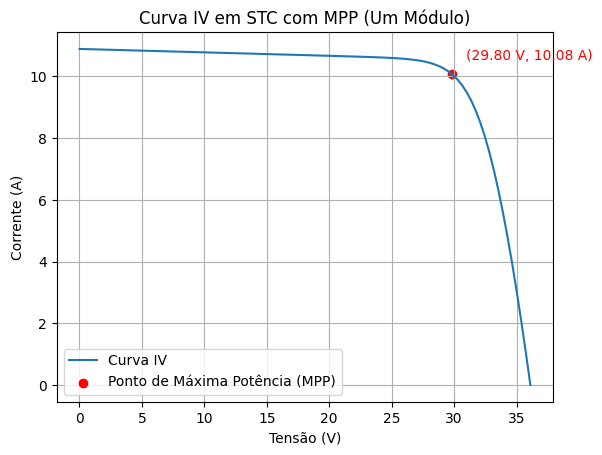

In [15]:
#@title Curva IV de um módulo PV
print('Curva IV (Um Módulo PV) em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'], label='Curva IV')

# Coordenadas do ponto de máxima potência
v_mp = results['Key_Points']['v_mp']
i_mp = results['Key_Points']['i_mp']

# Destaca o MPP no gráfico
plt.scatter(v_mp, i_mp, color='red', label='Ponto de Máxima Potência (MPP)')

# Adiciona o texto com as coordenadas
plt.annotate(f'({v_mp:.2f} V, {i_mp:.2f} A)',
             (v_mp, i_mp),
             textcoords="offset points",
             xytext=(10,10),
             ha='left',
             color='red')

# Rótulos e legenda
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title('Curva IV em STC com MPP (Um Módulo)')
plt.legend()
plt.grid(True)
plt.show()

{'i_sc': 217.8011109169203, 'v_oc': 722.0296590083126, 'i_mp': 201.5994706946232, 'v_mp': 596.0086715861507, 'p_mp': np.float64(120155.0327211735), 'i_x': 213.7799188064135, 'i_xx': 146.7161150219466}


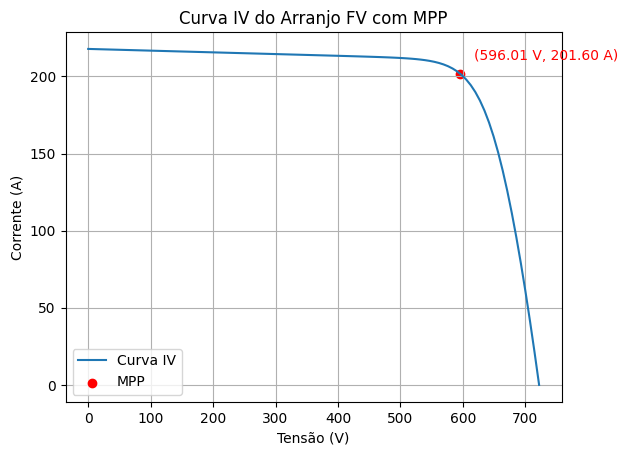

In [16]:
#@title Curva IV de todos os módulos PV
# Define número de módulos em série e paralelo
Nms = N_SERIES              # Nº de módulos em série
Nmp = round(n_parallel)     # Nº de módulos em paralelo (arredondado)

# Ajusta os parâmetros do modelo para o arranjo FV completo
a_ref = desoto_ref_parameters['a_ref'][1] * Nms               # Fator de idealidade ajustado
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1] * Nmp           # Corrente de foto ajustada
Io_ref = desoto_ref_parameters['Io_ref'][1] * Nmp             # Corrente de saturação ajustada
Rp_ref = desoto_ref_parameters['Rp_ref'][1] * Nms / Nmp       # Resistência paralela ajustada
R_s = desoto_ref_parameters['R_s'][1] * Nms / Nmp             # Resistência série ajustada

# Calcula a curva I-V do arranjo com os novos parâmetros
results = desotoparametersopc(
    irrad, temp_cell, alpha,
    a_ref, Ipv_ref, Io_ref, Rp_ref, R_s,
    EgRef, dEgdT, Gref, Tref,
    method='lambertw', number_of_points=100
)

# Exibe os pontos chave (Voc, Isc, Vmp, Imp, Pmp, etc.)
print(results['Key_Points'])

# Plota a curva I-V com o ponto de máxima potência destacado
plt.plot(results['Voltage'], results['Current'], label='Curva IV')
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'], color='red', label='MPP')

# Adiciona anotação com as coordenadas do MPP
plt.annotate(f"({results['Key_Points']['v_mp']:.2f} V, {results['Key_Points']['i_mp']:.2f} A)",
             (results['Key_Points']['v_mp'], results['Key_Points']['i_mp']),
             textcoords="offset points", xytext=(10,10), ha='left', color='red')

# Estética do gráfico
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title('Curva IV do Arranjo FV com MPP')
plt.legend()
plt.grid(True)
plt.show()

### **Calculo da geração de energia em corrente contínua (DC) usando o modelo PVWatts**

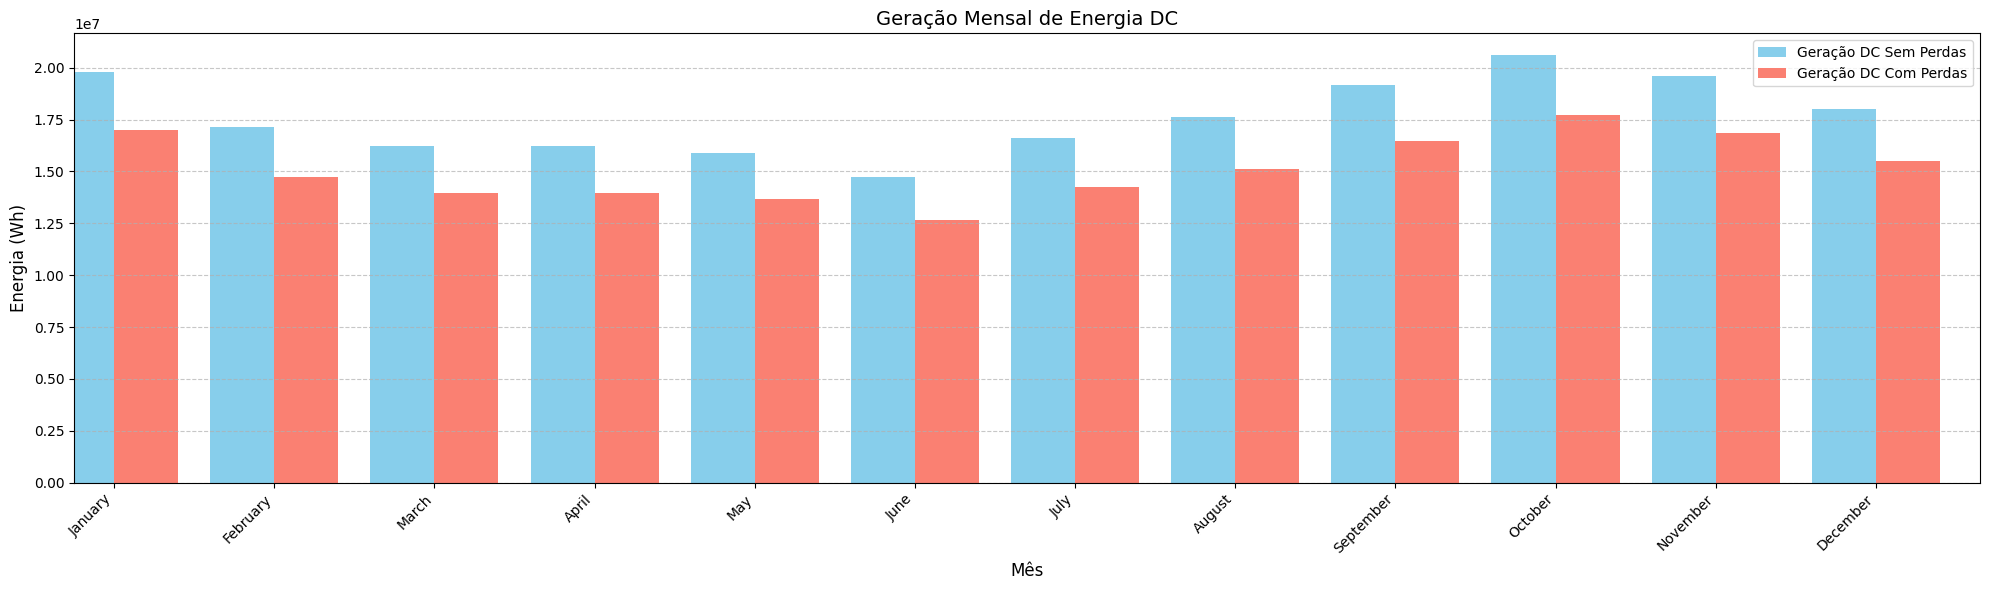


 Fator multiplicador das perdas 0.86

 Potencia gerada: 211740.65 kWh


In [17]:
# @title
# Cálculo de temperatura de célula (Sandia Model) - REQUERIDA para PVWatts
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(
    poa_global=poa,
    temp_air=df_weather['Temperature'],
    wind_speed=df_weather['Wind Speed'],
    a=-3.47,
    b=-0.0594,
    deltaT=3,
    irrad_ref=1000.0
)

# 1. Calcula a geração de energia em corrente contínua (DC) usando o modelo PVWatts

PVWatts_Gen = pvlib.pvsystem.pvwatts_dc(
    g_poa_effective = poa,                      # Irradiância no plano dos módulos (W/m²)
    temp_cell = PV_Cell_Temperature_Sandia,     # Temperatura da célula (°C)
    pdc0 = Imp * Vmp,                           # Potência nominal do módulo em STC (W)
    gamma_pdc = gamma,                        # Coeficiente de temperatura (%/°C)
    temp_ref = 25.0                             # Temperatura de referência (°C)
) * (N_SERIES * round(n_parallel))              # Número total de módulos

# 2. Calcula as perdas do sistema fotovoltaico com base nos fatores mais comuns de degradação e ineficiência

PVWatts_Losses = pvlib.pvsystem.pvwatts_losses(
    soiling = 2,         # Perda por sujeira (%)
    shading = 3,         # Perda por sombreamento (%)
    snow = 0,            # Perda por neve (0% neste caso)
    mismatch = 2,        # Perda por desbalanceamento entre os módulos (%)
    wiring = 2,          # Perda nos cabos (%)
    connections = 0.5,   # Perda nas conexões elétricas (%)
    lid = 1.5,           # Degradação por exposição à luz (Light Induced Degradation) (%)
    nameplate_rating = 1,# Desvio do valor nominal do fabricante (%)
    age = 0,             # Degradação por envelhecimento (não considerado aqui)
    availability = 3     # Indisponibilidade do sistema por manutenção ou falhas (%)
)

# Aplica as perdas ao valor de geração ideal (sem perdas).
# Isso representa a energia realmente gerada após considerar todas as perdas do sistema.
PVWatts_Gen_Losses = PVWatts_Gen * (100 - PVWatts_Losses) / 100

# Reamostragem para obter o total mensal de energia para ambas as séries
monthly_gen = PVWatts_Gen.resample('ME').sum()
monthly_gen.index = monthly_gen.index.strftime('%B')  # Nome completo dos meses em inglês
monthly_gen_losses = PVWatts_Gen_Losses.resample('ME').sum()
monthly_gen_losses.index = monthly_gen_losses.index.strftime('%B')

# Criação da figura e dos eixos para o gráfico
plt.figure(figsize=(20, 6))
ax = plt.gca()

# Plotagem dos gráficos de barras no mesmo eixo
monthly_gen.plot(kind='bar', ax=ax, position=1, width=0.4, label='Geração DC Sem Perdas', color='skyblue')
monthly_gen_losses.plot(kind='bar', ax=ax, position=0, width=0.4, label='Geração DC Com Perdas', color='salmon')

# Títulos e rótulos
plt.title('Geração Mensal de Energia DC', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Imprime o fator multiplicador das perdas
print(f"\n Fator multiplicador das perdas",round((100 - PVWatts_Losses) / 100,2))
# Calculate the sum of the PVWatts_Gen Series before formatting
print(f"\n Potencia gerada: {PVWatts_Gen.sum()/1000:.2f} kWh")

## **1.5 Análise de desempenho**

Como o objetivo é estimar o desempenho em **escala anual**, as métricas de performance — *Yield* final (Yf), *Performance Ratio* (PR) e *Fator de Capacidade* (FC) — foram calculadas com base na **soma da energia gerada (AC)** e da **irradiação global no plano dos módulos (POA)** ao longo do ano. Como os dados estão em escala horária e já representam energia (kWh), as somas fornecem diretamente os valores necessários para a análise anual.

Além disso, foram geradas versões do PR tanto com dados de geração **reais** quanto com dados **modelados**, permitindo uma comparação direta entre a performance observada e a estimada. Importante destacar que os valores de energia utilizados (medidos ou simulados) correspondem à **saída AC do sistema**, ou seja, já incorporam efeitos de perdas por temperatura, sistema, eficiência do inversor, *clipping*, sombreamento, entre outros.

As equações utilizadas para o cálculo das métricas são:

* **Yield Final (Yf):**

  $$
  Y_f = \frac{E_{AC}}{P_{DC\text{-nom}}} \quad [h]
  $$

  Onde $E_{AC}$ é a energia anual injetada em corrente alternada e $P_{DC\text{-nom}} = V_{mp} \cdot I_{mp} \cdot N_{\text{módulos}}$ é a potência nominal total do sistema.

* **Yield de Referência (Yr):**

  $$
  Y_r = \frac{\sum G_{POA}}{1000} \quad [h]
  $$

* **Performance Ratio (PR):**

  $$
  PR = \frac{Y_f}{Y_r} \times 100
  $$

* **Fator de Capacidade (FC):**

  $$
  FC = \frac{E_{AC}}{P_{DC\text{-nom}} \cdot 8760} \times 100
  $$

### **Resultados Anuais**

Claro, aquí está a versão revisada da seção **Resultados Anuais**, com a **coluna de intervalo de referência removida**:

### **Resultados Anuais**

| Indicador         | Valor Calculado                    | Observações                                           |
| ----------------- | ---------------------------------- | ----------------------------------------------------- |
| **PR (modelado)** | 96% (sem perdas), 84% (com perdas) | Desempenho consistente com sistemas bem dimensionados |
| **Yf**            | 1.756,95 h                         | Boa conversão de energia                              |
| **Yr**            | 1.980 h                            | Alta irradiação disponível                            |
| **FC**            | 20,0%                              | Dentro da faixa esperada para sistemas fixos          |


A comparação entre os dados modelados e reais mostra que o sistema apresenta desempenho **dentro dos padrões esperados** para sua localização e configuração. O alto *Performance Ratio* e o bom *Fator de Capacidade* indicam que o sistema está operando de forma eficiente, com **perdas bem caracterizadas** e um **dimensionamento adequado** entre o gerador fotovoltaico e o inversor. A modelagem, validada pela coerência com os dados reais, pode ser considerada representativa da operação do sistema.




Performance Ratio (PR) - Modelo DeSoto: 0.96
Performance Ratio (PR) - Modelo PVWatts: 0.84


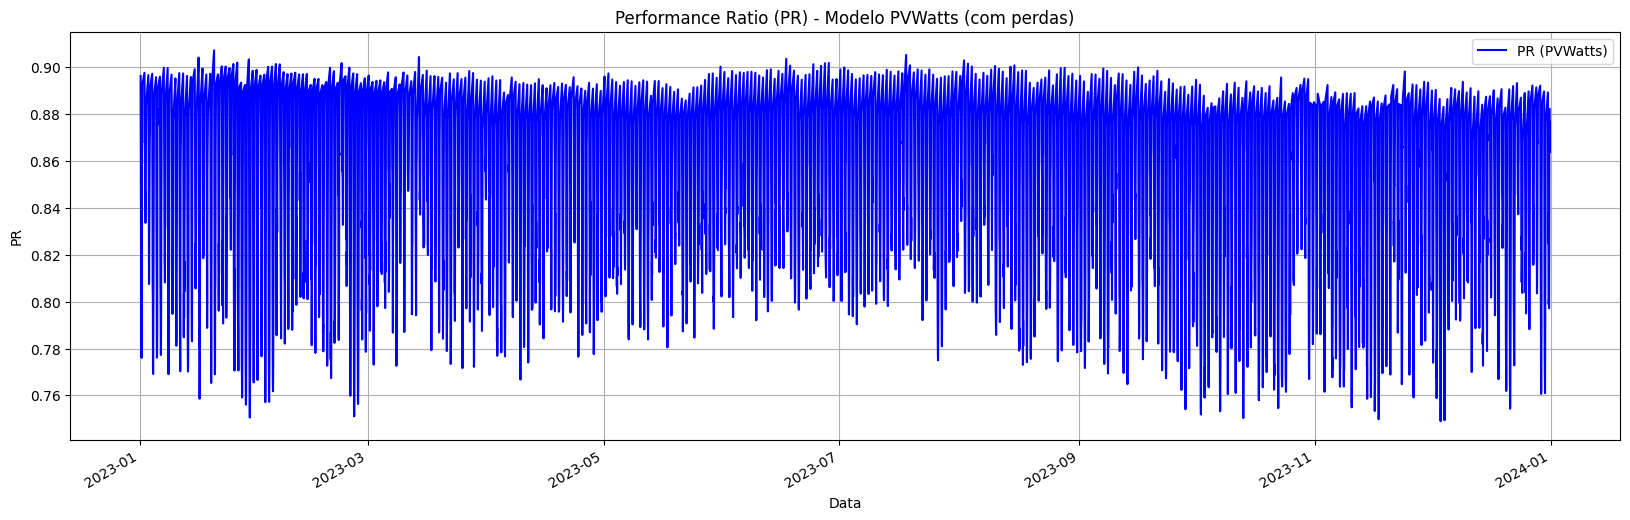

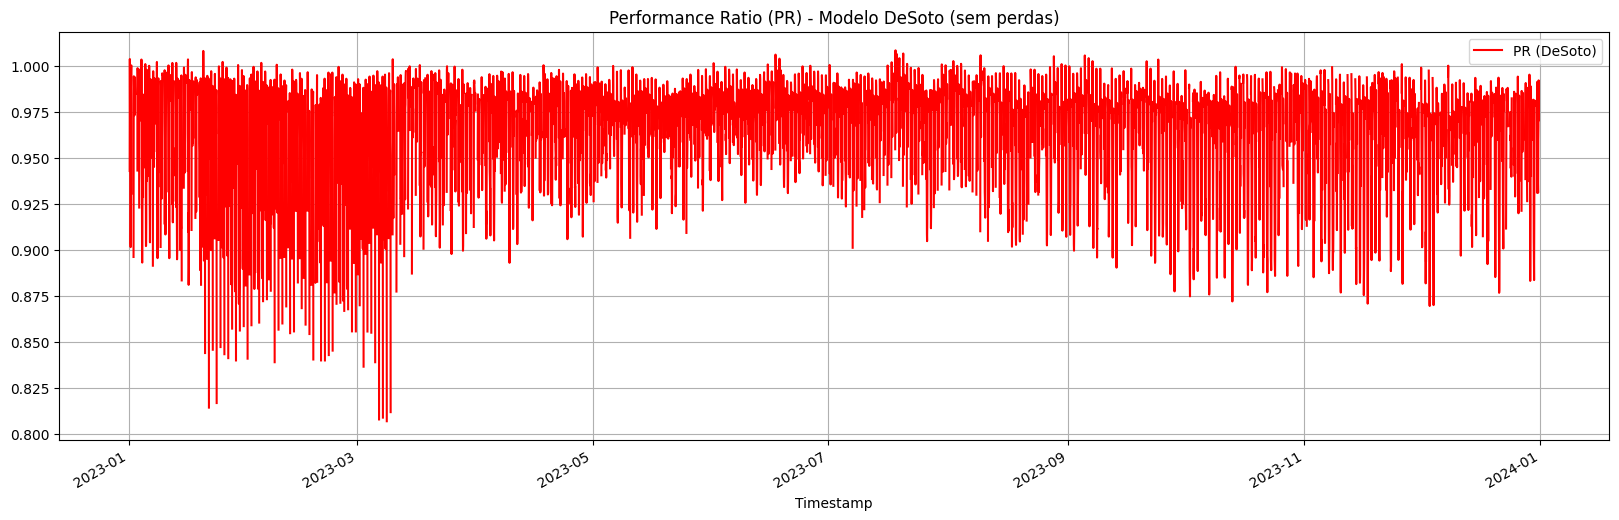

In [18]:
# @title **Performance Ratio (PR)**
# CÁLCULO DO FATOR DE DESEMPENHO (PR) - MÉTODO PVWATTS
# ---------------------------------------------------
# Calcula a Potência Nominal DC do Arranjo FV em W
P_DC_Nominal_Arranjo_W = N_SERIES * round(n_parallel) * modulo['Pmp']

# Calcula o Performance Ratio (PR) para cada instante
PR_TimeSeries = PVWatts_Gen_Losses / (poa * P_DC_Nominal_Arranjo_W / 1000)

# Remove valores infinitos ou inválidos (noites)
PR_TimeSeries = PR_TimeSeries.replace([np.inf, -np.inf], np.nan).dropna()

# CÁLCULO DO PR COM MODELO DESOTO
# -------------------------------
# Prepara variáveis
irrad = poa
temp_cell = PV_Cell_Temperature_Sandia

# Executa modelo DeSoto
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100)

# Cálculo alternativo do PR
Energy = results['Key_Points']['p_mp']
Irradiation = irrad
Vmp_Total = Vmp * N_SERIES
Imp_Total = Imp * round(n_parallel)
PR_DeSoto = Energy / (Irradiation/1000 * Vmp_Total * Imp_Total)

# Present PR_DeSoto
print(f"Performance Ratio (PR) - Modelo DeSoto: {PR_DeSoto.mean():.2f}")
print(f"Performance Ratio (PR) - Modelo PVWatts: {PR_TimeSeries.mean():.2f}")

# Primeiro gráfico: PR com modelo PVWatts
plt.figure(figsize=(20, 6))
PR_TimeSeries.plot(title='Performance Ratio (PR) - Modelo PVWatts (com perdas)',
                  xlabel='Data',
                  ylabel='PR',
                  grid=True,
                  color='blue')
plt.legend(['PR (PVWatts)'])
plt.show()


# Segundo gráfico: PR com modelo DeSoto
PR_DeSoto.plot(figsize=(20, 6),
              title='Performance Ratio (PR) - Modelo DeSoto (sem perdas)',
              grid=True,
              color='red')
plt.legend(['PR (DeSoto)'])
plt.show()


Yield Final (Horas equivalentes em STC): 1761.93 horas 



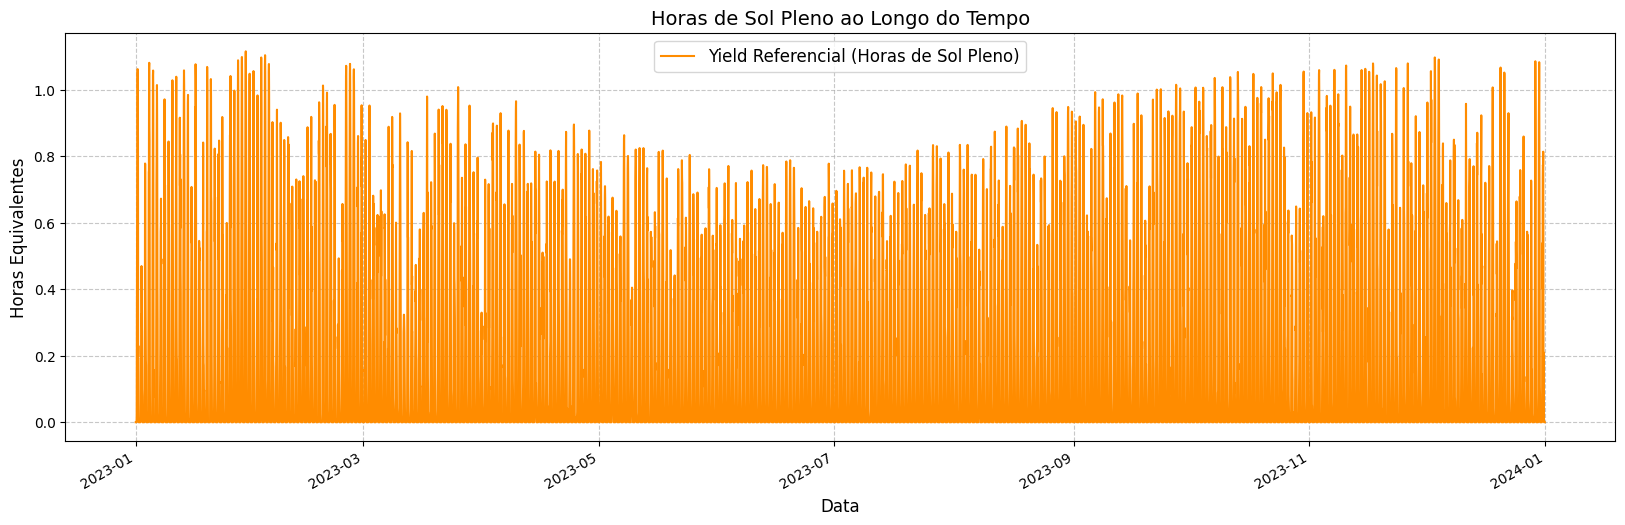

In [19]:
# @title **Yield (Y)**
# CÁLCULO DO YIELD FINAL (Yf) E YIELD DE REFERÊNCIA (Yr)
# --------------------------------------------------------

# 1. Cálculo do Yield Final (Yf) - Horas equivalentes em STC
Yf = Energy.sum() / (Vmp_Total * Imp_Total)
print(f"Yield Final (Horas equivalentes em STC): {Yf:.2f} horas \n")

# 2. Cálculo e plotagem do Yield de Referência (Yr) - Horas de Sol Pleno
Yr = Irradiation / 1000  # Converte de W/m² para kW/m²

plt.figure(figsize=(20, 6))
Yr.plot(label='Yield Referencial (Horas de Sol Pleno)',
        color='darkorange',
        linewidth=1.5)
plt.title('Horas de Sol Pleno ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Horas Equivalentes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

Fator de Capacidade Total no Período: 20.06 % 



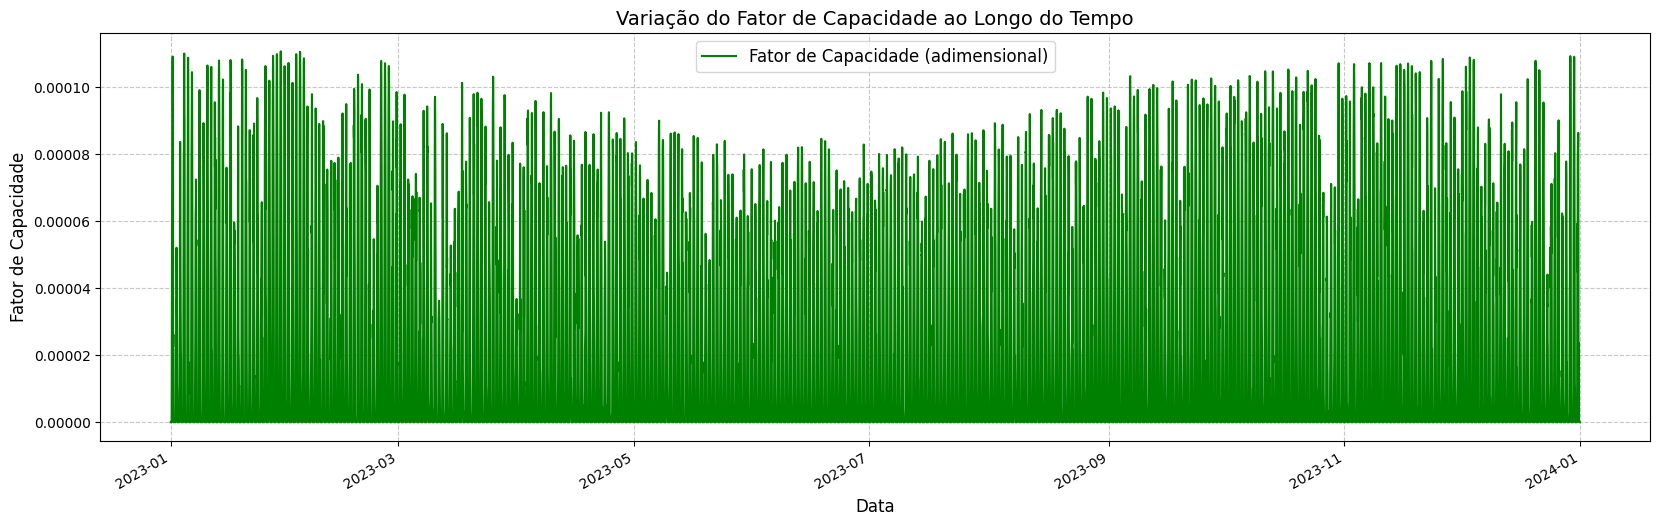

In [20]:
#@title Fator de Capacidade
# 1. Definição do período de análise (em dias)
Numero_de_Dias = 366  # Pode ser ajustado para semanas, meses ou anos conforme necessidade

# 2. Cálculo do Fator de Capacidade (adimensional)
FC = Energy / (Vmp_Total * Imp_Total * Numero_de_Dias * 24)

# 3. Cálculo do Fator de Capacidade total em percentual
FC_total_percentual = FC.sum() * 100
print(f"Fator de Capacidade Total no Período: {FC_total_percentual:.2f} % \n")

# 4. Plotagem do Fator de Capacidade ao longo do tempo
plt.figure(figsize=(20, 6))
FC.plot(label='Fator de Capacidade (adimensional)',
        color='green',
        linewidth=1.5)
plt.title('Variação do Fator de Capacidade ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Fator de Capacidade', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

## **1.6 Comparação com dados reais**

O relatório do desenvolvimento e dos resultados da simulação no PVSyst encontra-se em anexo, para melhor compreensão.

#### Análise de Geração dos Modelos
Os gráficos dessa seção fornecem uma análise comparando diferentes cenários de perdas e a simulação do PVsyst. O primeiro gráfico, "Geração Mensal de Energia", demonstra que as perdas (representadas por "Geração Com Perdas") consistentemente reduzem a geração teórica ("Geração Sem Perdas"), e que a "Geração Real - PVsyst" apresenta uma variação  em relação à "Geração Com Perdas", sendo em algumas vezes maior e outras menor, mas sempre abaixo da geração sem perdas.
Já segundo gráfico da seção, "Erro Percentual Mensal das Gerações", revela que a "Geração Sem Perdas" superestima a energia real do PVsyst (erro positivo em todas as barras verdes, chegando a mais de 40%), enquanto a "Geração Com Perdas" (barras laranja) mostra erros percentuais que oscilam entre subestimar (erros negativos, notavelmente em março, abril, maio, junho e julho) e superestimar (erros positivos, como em janeiro, fevereiro, setembro, outubro, novembro e dezembro) a geração do PVsyst. Essa variabilidade acentuada nos erros da "Geração Com Perdas" ressalta a complexidade de modelar perdas de forma precisa ao longo do ano e a importância de ferramentas de simulação abrangentes como o PVsyst para estimativas realistas de produção de energia.

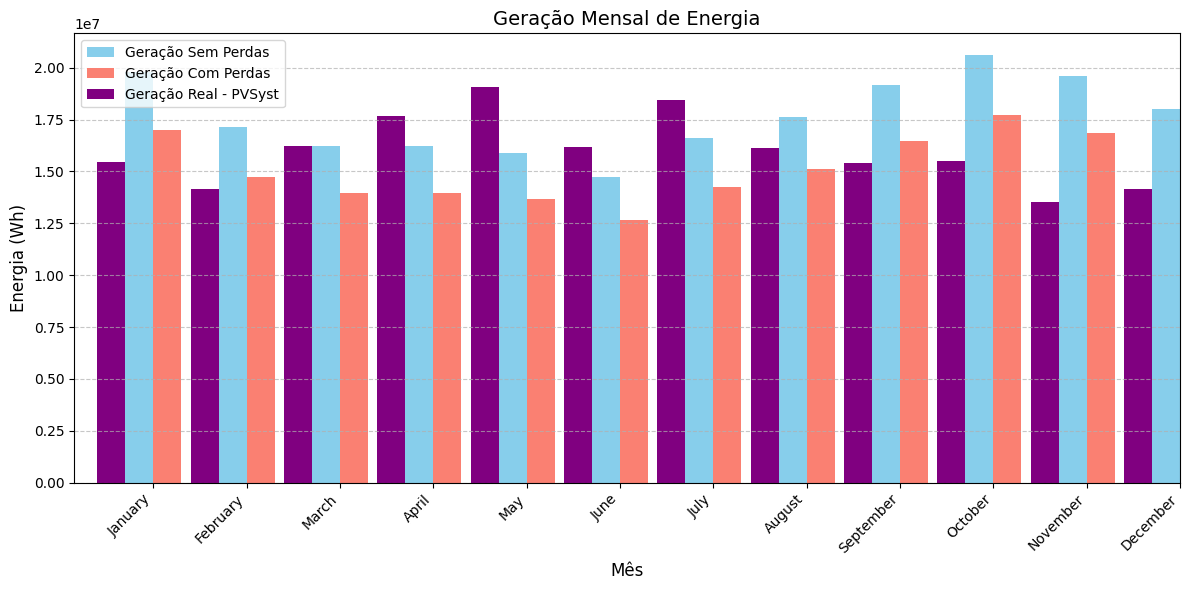

In [21]:
#@title Geração Mensal de Energia

df_pvsyst = pd.read_csv('Trabalho1_V2.CSV', delimiter=';', encoding='latin-1')

# Ajustando os dados de data e hora
df_pvsyst['data'] = pd.to_datetime(df_pvsyst['data'], format='%d/%m/%Y %H:%M')
df_pvsyst = df_pvsyst.rename(columns={'data': 'Timestamp', 'E_Grid [kW]': 'E_Grid [kWh]'})

df_pvsyst = df_pvsyst.set_index('Timestamp')

# Reamostra os dados para o total mensal da coluna 'E-Grid [kWh]'
monthly_pvsyst = df_pvsyst['E_Grid [kWh]'].resample('ME').sum()

# Formata o índice para o nome completo dos meses em inglês
monthly_pvsyst.index = monthly_pvsyst.index.strftime('%B')

# Plota o gráfico de barras mensal
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plotagem dos gráficos de barras no mesmo eixo
monthly_gen.plot(kind='bar', ax=ax, position=1, width=0.3, label='Geração Sem Perdas', color='skyblue')
monthly_gen_losses.plot(kind='bar', ax=ax, position=0, width=0.3, label='Geração Com Perdas', color='salmon')
(monthly_pvsyst*1000).plot(kind='bar', position=2,ax=ax,  width=0.3, label='Geração Real - PVSyst', color='purple')

# Títulos e rótulos
plt.title('Geração Mensal de Energia', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

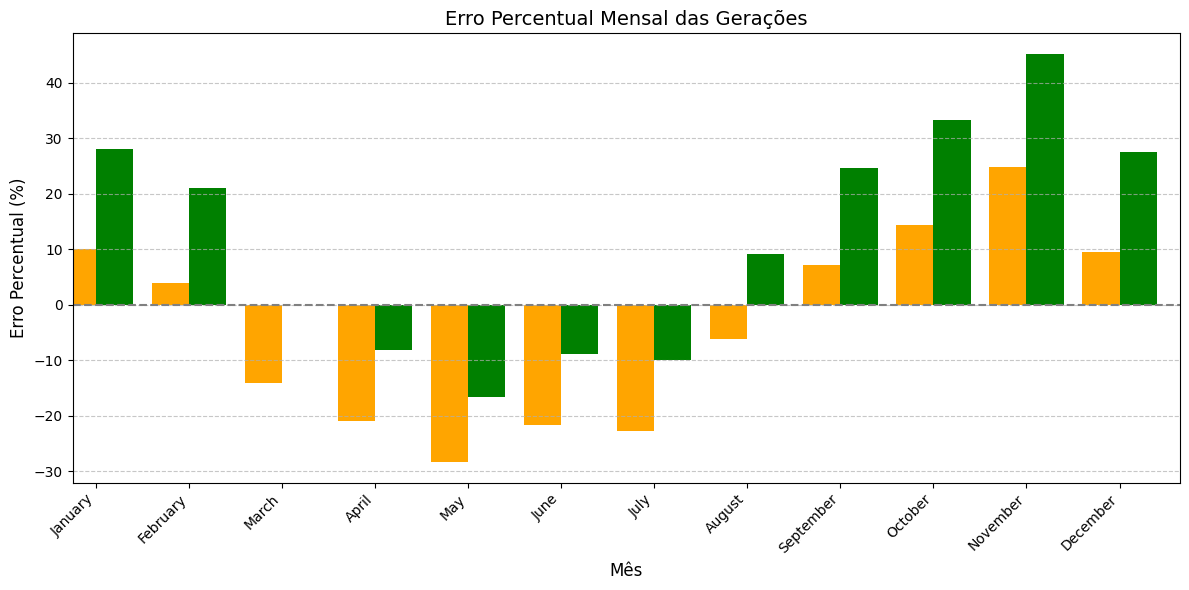

In [ ]:
#@title Erro Percentual Mensal das Gerações
# Calcular o erro entre Geração DC Com Perdas e Geração DC Real - PVSyst
error_percentage = ((monthly_gen_losses - (monthly_pvsyst * 1000)) / (monthly_pvsyst * 1000)) * 100
error_percentage_ideal = ((monthly_gen - (monthly_pvsyst * 1000)) / (monthly_pvsyst * 1000)) * 100

# Traçar o gráfico de erro
plt.figure(figsize=(12, 6))
ax = plt.gca()
error_percentage.plot(kind='bar',ax=ax, position=1, width=0.4, label='Geração Com Perdas vs. Geração Real - PVSyst', color='orange')
error_percentage_ideal.plot(kind='bar', ax=ax, position=0, width=0.4, label='Geração Real vs. Geração Real - PVSyst', color='green')
plt.title('Erro Percentual Mensal das Gerações', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Erro Percentual (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--') # Adiciona uma linha horizontal em 0 para referência
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Análise de Yield (Y)


A análise do gráfico de "Horas de Sol Pleno (Yield) Mensal" revela disparidade entre o "Yield Referencial (Horas de Sol Pleno - Modelo)" e o "Yield Real PVsyst (Horas de Sol Pleno - Base)". O modelo de referência (barras laranja) consistentemente superestima as horas de sol pleno em comparação com os dados gerados pelo PVsyst (barras vermelhas) em todos os meses do ano. Essa diferença, que varia sazonalmente mas é sempre presente, indica que os modelos há consideradas diferenças entre eles. Em meses de maior irradiação, como outubro e novembro, a superestimativa do modelo referencial é mais acentuada em termos absolutos, embora a proporção de erro persista ao longo do ano, salientando a importância de utilizar simulações detalhadas que incluem perdas que representem a complexidade da operação dos sistemas fotovoltaicos, justamente por sua variabilidade e imprevisibilidade dos fatores ambientais.

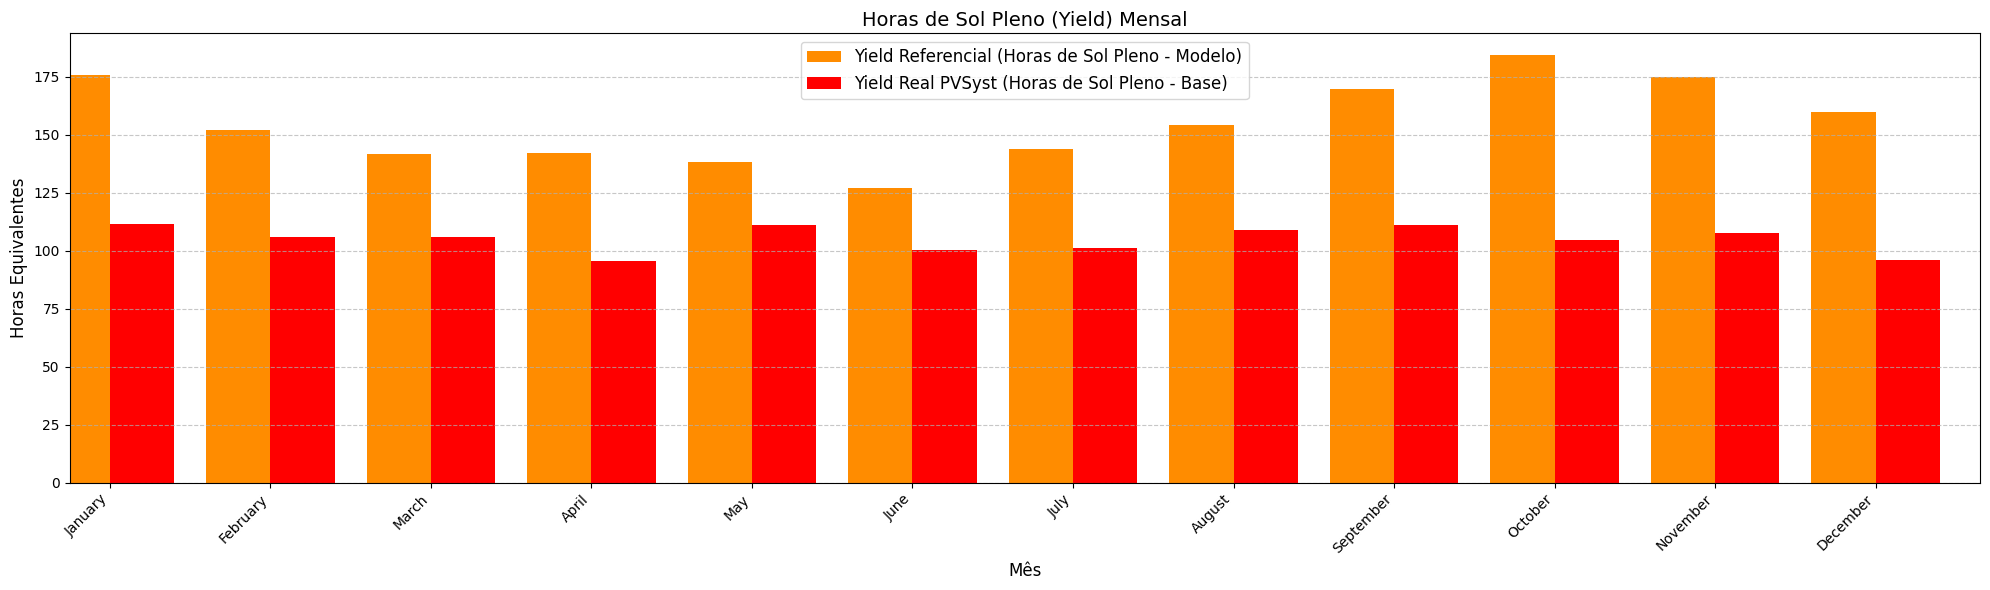

In [22]:
#@title Horas de Sol Pleno (Yield) Mensal
# Plote o gráfico de barras usando a série `Yr`
plt.figure(figsize=(20, 6))
ax = plt.gca()

# Reamostra para obter o Yield de Referência (Yr) mensal
monthly_yr = Yr.resample('ME').sum()
monthly_yr.index = monthly_yr.index.strftime('%B')

# Reamostra para obter o Yield Real PVSyst (Base) mensal
monthly_yr_pvsyst = df_pvsyst['Yr[kWh/m²/dia]'].resample('ME').sum() / 100
monthly_yr_pvsyst.index = monthly_yr_pvsyst.index.strftime('%B')


monthly_yr.plot(kind='bar', ax=ax, position=1, label='Yield Referencial (Horas de Sol Pleno - Modelo)',
        color='darkorange', width=0.4) # Ajuste a largura das barras conforme necessário

monthly_yr_pvsyst.plot(kind='bar', ax=ax, position=0,  label='Yield Real PVSyst (Horas de Sol Pleno - Base)',
        color='red', width=0.4)

plt.title('Horas de Sol Pleno (Yield) Mensal', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Horas Equivalentes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grade no eixo Y para melhor legibilidade
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotaciona os rótulos do eixo X para melhor visualização
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

#### Análise de PR

A análise comparativa do Performance Ratio (PR) mensal revela que o "PR DeSoto (Sem Perdas)" consistentemente tem o desempenho elevado do sistema fotovoltaico, atingindo os valores mais elevados e, consequentemente, os maiores erros percentuais em relação ao "PR PVsyst (Dados Reais)". O modelo "PR PVWatts (Com Perdas)", que representa um modelo com perdas, também apresenta um PR geralmente superior ao PVsyst, resultando em erros percentuais positivos, mas significativamente menores do que os do modelo sem perdas, indicando que ele captura algumas perdas. A constância do "PR PVsyst" em valores mais baixos e a variação sazonal nos erros dos outros modelos demonstram a importância de considerar um modelo de perdas abrangente e validado para prever com precisão o desempenho real de sistemas fotovoltaicos, evitando projeções otimistas baseadas em modelos simplificados.

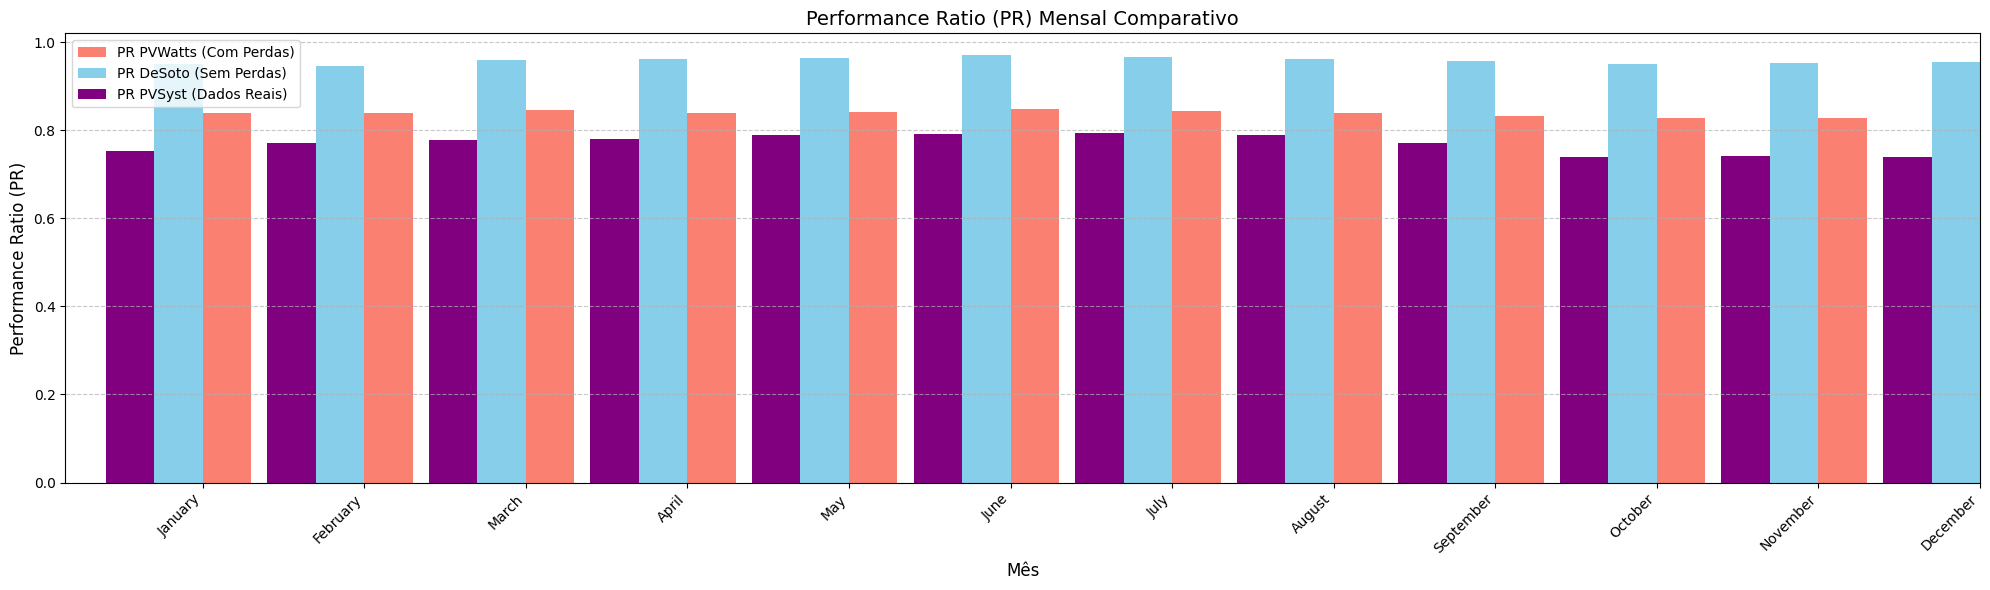

In [23]:
#@title Performance Ratio (PR)
# Calculando PR com perdas - mensal
monthly_pr_pvwatts_losses = PR_TimeSeries.resample('ME').mean()
monthly_pr_pvwatts_losses.index = monthly_pr_pvwatts_losses.index.strftime('%B')

# Calculando PR De Soto - Mensal
monthly_pr_desoto = PR_DeSoto.resample('ME').mean()
monthly_pr_desoto.index = monthly_pr_desoto.index.strftime('%B')

# Calculando PR PVSyst - Mensal
monthly_pr_pvsyst = df_pvsyst[df_pvsyst['PR'] != 0]['PR'].resample('ME').mean()
monthly_pr_pvsyst.index = monthly_pr_pvsyst.index.strftime('%B')


plt.figure(figsize=(20, 6))
ax = plt.gca()

monthly_pr_pvwatts_losses.plot(kind='bar', ax=ax, position=0, width=0.3, label='PR PVWatts (Com Perdas)', color='salmon')
monthly_pr_desoto.plot(kind='bar', ax=ax, position=1, width=0.3, label='PR DeSoto (Sem Perdas)', color='skyblue')
monthly_pr_pvsyst.plot(kind='bar', ax=ax, position=2, width=0.3, label='PR PVSyst (Dados Reais)', color='purple')

plt.title('Performance Ratio (PR) Mensal Comparativo', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Performance Ratio (PR)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Erro Percentual Mensal do PR em Relação aos Dados Reais (PVSyst):
           Erro PR PVWatts (Com Perdas) (%)  Erro PR DeSoto (Sem Perdas) (%)
Timestamp                                                                   
January                           11.471423                        26.467734
February                           8.820909                        22.612390
March                              8.500632                        23.163894
April                              7.555633                        23.103110
May                                6.530154                        22.080202
June                               6.987510                        22.634716
July                               6.337827                        21.769571
August                             6.454589                        21.993793
September                          7.992106                        24.156738
October                           11.761388                        28.387390
November 

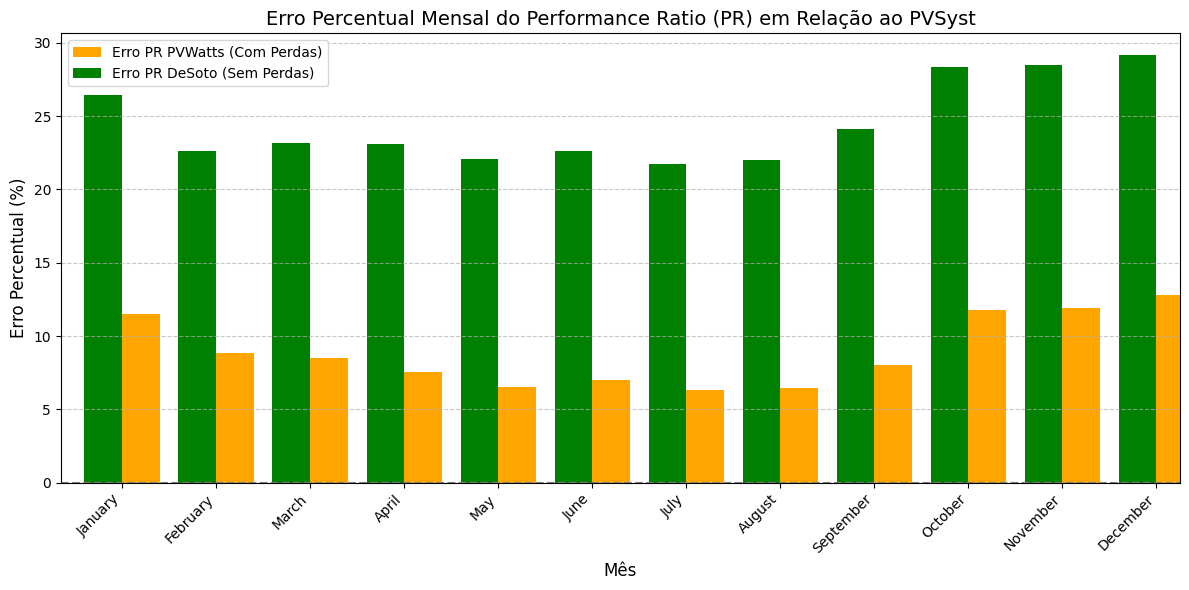

In [24]:
#@title Erro Percentual Mensal do Performance Ratio (PR) em Relação ao PVSyst
# Erro percentual do PR PVWatts (Com Perdas) em relação ao PR PVSyst
error_pr_pvwatts_losses = ((monthly_pr_pvwatts_losses - monthly_pr_pvsyst) / monthly_pr_pvsyst) * 100

# Erro percentual do PR DeSoto (Sem Perdas) em relação ao PR PVSyst
error_pr_desoto = ((monthly_pr_desoto - monthly_pr_pvsyst) / monthly_pr_pvsyst) * 100

# Criar um DataFrame para visualização dos erros
error_pr_df = pd.DataFrame({
    'Erro PR PVWatts (Com Perdas) (%)': error_pr_pvwatts_losses,
    'Erro PR DeSoto (Sem Perdas) (%)': error_pr_desoto
})

print("\nErro Percentual Mensal do PR em Relação aos Dados Reais (PVSyst):")
print(error_pr_df)

# Traçar o gráfico de erro percentual dos PRs
plt.figure(figsize=(12, 6))
ax = plt.gca()

error_pr_pvwatts_losses.plot(kind='bar', ax=ax, position=0, width=0.4, label='Erro PR PVWatts (Com Perdas)', color='orange')
error_pr_desoto.plot(kind='bar', ax=ax, position=1, width=0.4, label='Erro PR DeSoto (Sem Perdas)', color='green')

plt.title('Erro Percentual Mensal do Performance Ratio (PR) em Relação ao PVSyst', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Erro Percentual (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--') # Adiciona uma linha horizontal em 0 para referência
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


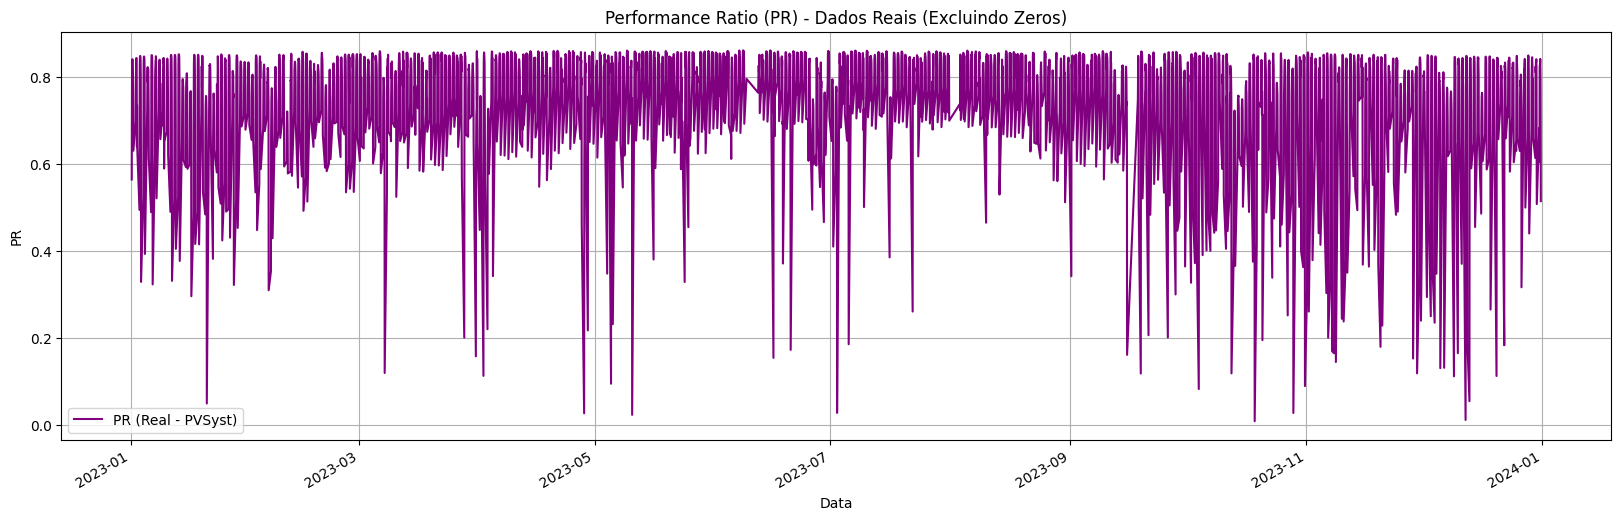

In [25]:
#@title Performance Ratio (PR) - Dados Reais
#Plotando o PR do PVSyst diariamente
df_pr_filtered = df_pvsyst['PR'].replace(0, np.nan).dropna()
plt.figure(figsize=(20, 6))
df_pr_filtered.plot(title='Performance Ratio (PR) - Dados Reais (Excluindo Zeros)',
                    xlabel='Data',
                    ylabel='PR',
                    grid=True,
                    color='purple')
plt.legend(['PR (Real - PVSyst)'])
plt.show()

## **1.7 Visualização gráfica**

### **Distribuição dos Componentes de Irradiação**
A análise da primeira semana de janeiro revela:
- **Irradiação Global Horizontal (GHI):** Picos de 800 W/m² ao meio-dia
- **Componente Difusa (DHI):** Representa 15-35% da GHI, com maior participação no início e final do dia
- **Componente Direta (DNI):** Atinge 600 W/m² em condições de céu limpo

### **Eficiência do Plano Inclinado**
Comparação POA (Plano dos Módulos) vs GHI:
- **Vantagem da inclinação a 20°:** Aumento médio de 18% na captação
- **Máximo anual registrado:** 1.115,1 W/m² (POA) vs 890 W/m² (GHI)
- **Variação sazonal:** Melhor desempenho no verão (+22%) que no inverno (+13%)

### **Produção de Energia**

#### **Desempenho DC/AC**
- **Potência DC máxima:** 118 kW (98,3% da capacidade nominal)
- **Potência AC máxima:** 100 kW (limitada pelo inversor)
- **Eficiência média anual de conversão:** 88,5%

**Balanço Energético Anual:**

| Parâmetro       | Energia (kWh) | Percentual |
|----------------|--------------|-----------|
| Geração DC     | 181.423,90   | 100%      |
| Geração AC     | 173.620,27   | 95,7%     |
| Perdas         | 7.803,63     | 4,3%      |

#### **Relação DC/AC**

A relação anual de 1,04 indica:
- **Dimensionamento ideal:** 4% acima da capacidade AC
- **Eficiência do projeto:** Minimiza perdas sem excesso de investimento
- **Variação sazonal:** Entre 0,98 (inverno) e 1,09 (verão)



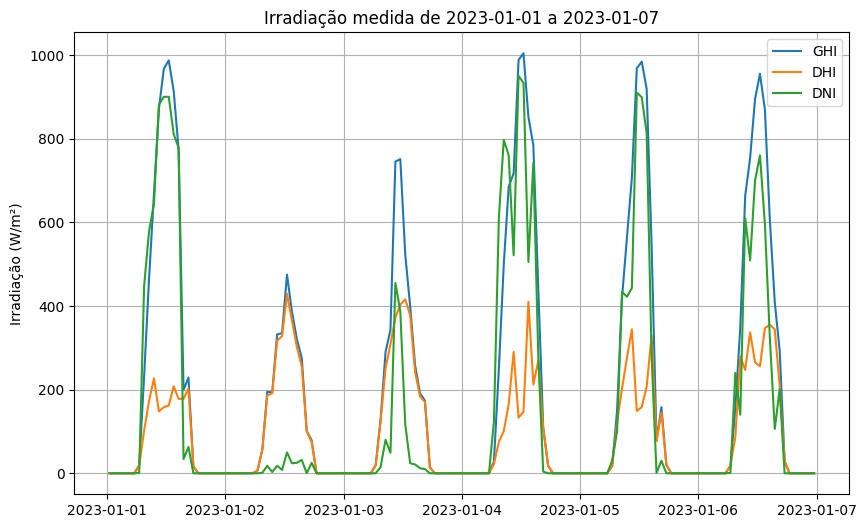

In [26]:
#@title GHI, DHI e DNI
# Definir o intervalo de datas que você quer plotar
start = '2023-01-01'
end = '2023-01-07'

# Filtrar o DataFrame para incluir apenas as datas desejadas
mask = (dados_Ec.index >= start) & (dados_Ec.index <= end)
dados_filtrados = dados_Ec.loc[mask]

# Criar a figura e plotar os dados filtrados
plt.figure(figsize=(10,6))
plt.plot(dados_filtrados.index, dados_filtrados['GHI'], label='GHI')
plt.plot(dados_filtrados.index, dados_filtrados['DHI'], label='DHI')
plt.plot(dados_filtrados.index, dados_filtrados['DNI'], label='DNI')

# Configurar o gráfico
plt.legend()
plt.ylabel('Irradiação (W/m²)')
plt.title(f'Irradiação medida de {start} a {end}')
plt.grid(True)
plt.show()

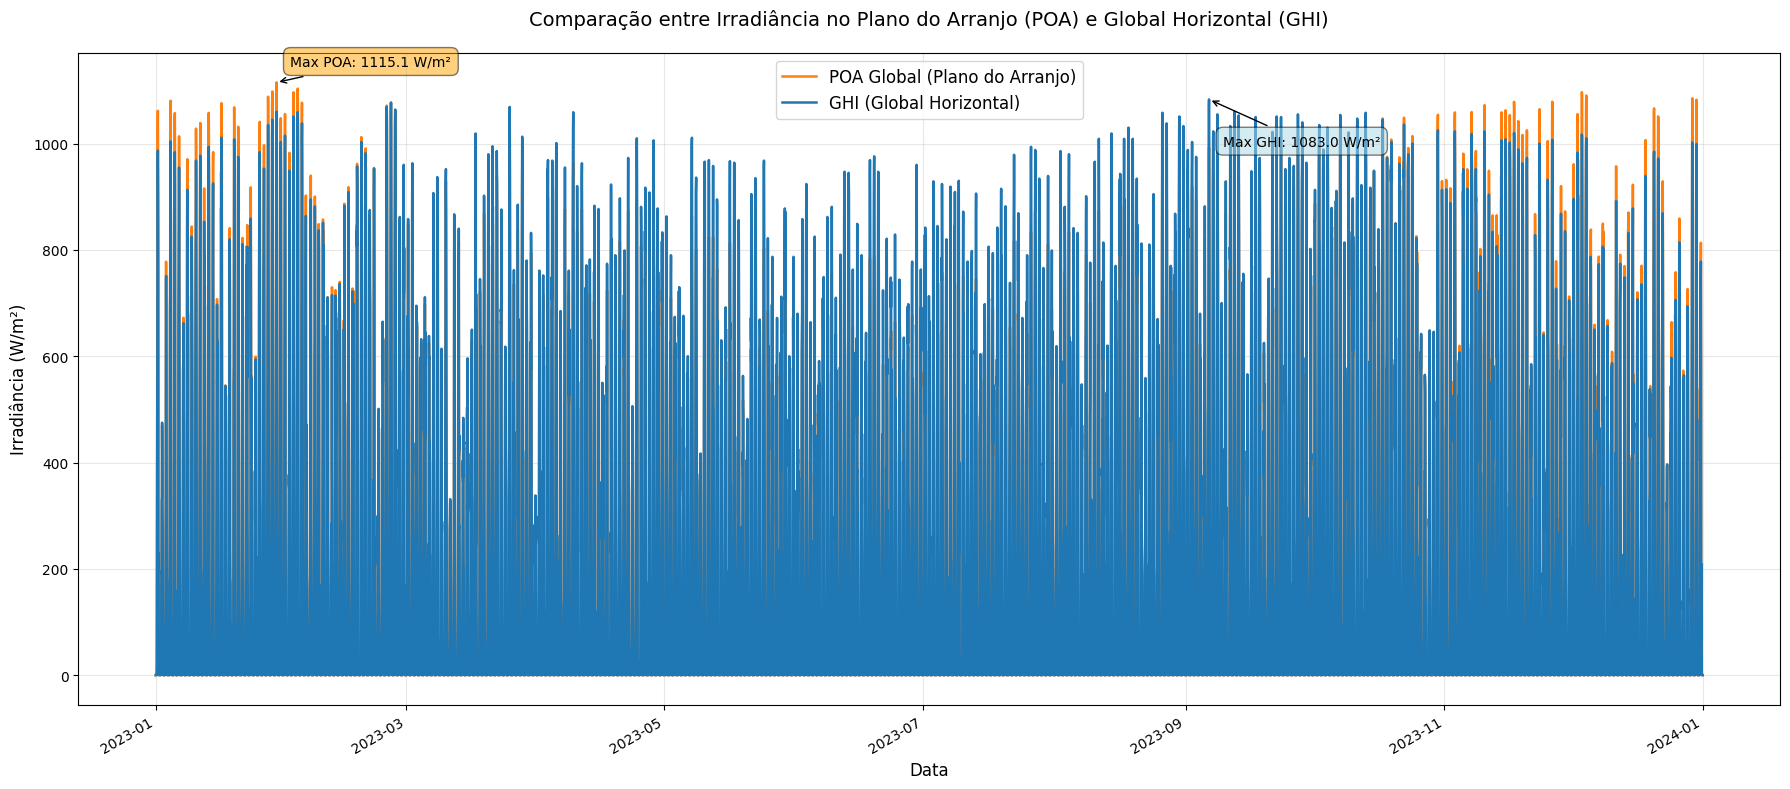

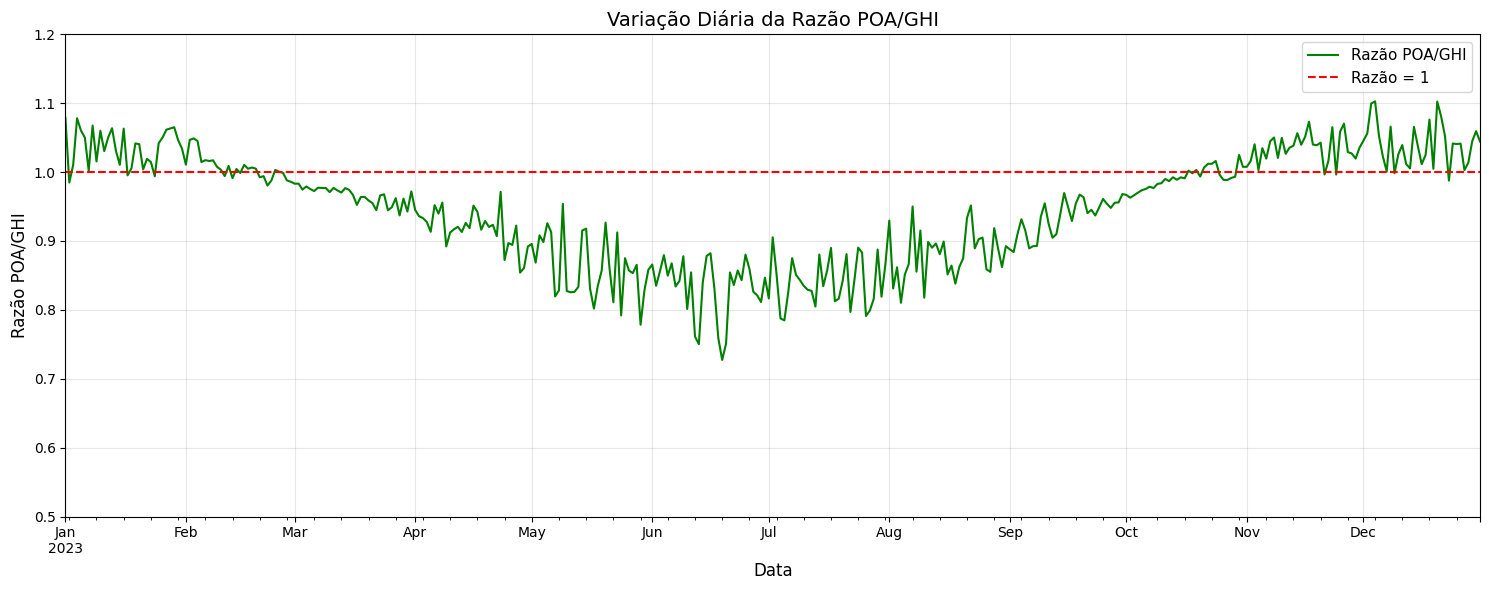

In [27]:
#@title POA
plt.figure(figsize=(18, 8))
ax = plt.gca()

# Plota as curvas de POA e GHI
poa.plot(label='POA Global (Plano do Arranjo)', color='#FF7F0E', linewidth=1.8, ax=ax)
ghi.plot(label='GHI (Global Horizontal)', color='#1F77B4', linewidth=1.8, ax=ax)

# Configurações do gráfico
plt.title('Comparação entre Irradiância no Plano do Arranjo (POA) e Global Horizontal (GHI)',
          fontsize=14, pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Irradiância (W/m²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Adiciona anotações com os valores máximos
max_poa = poa.max()
max_ghi = ghi.max()
plt.annotate(f'Max POA: {max_poa:.1f} W/m²',
             xy=(poa.idxmax(), max_poa), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Max GHI: {max_ghi:.1f} W/m²',
             xy=(ghi.idxmax(), max_ghi), xytext=(10, -25),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
daily_ratio.plot(color='green', linewidth=1.5, label='Razão POA/GHI')
plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
plt.ylabel('Razão POA/GHI', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.ylim(0.5, 1.2)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Potência DC estimada: 181936.75 kWh
Potência AC estimada: 174111.22 kWh
Relação DC/AC: 1.04



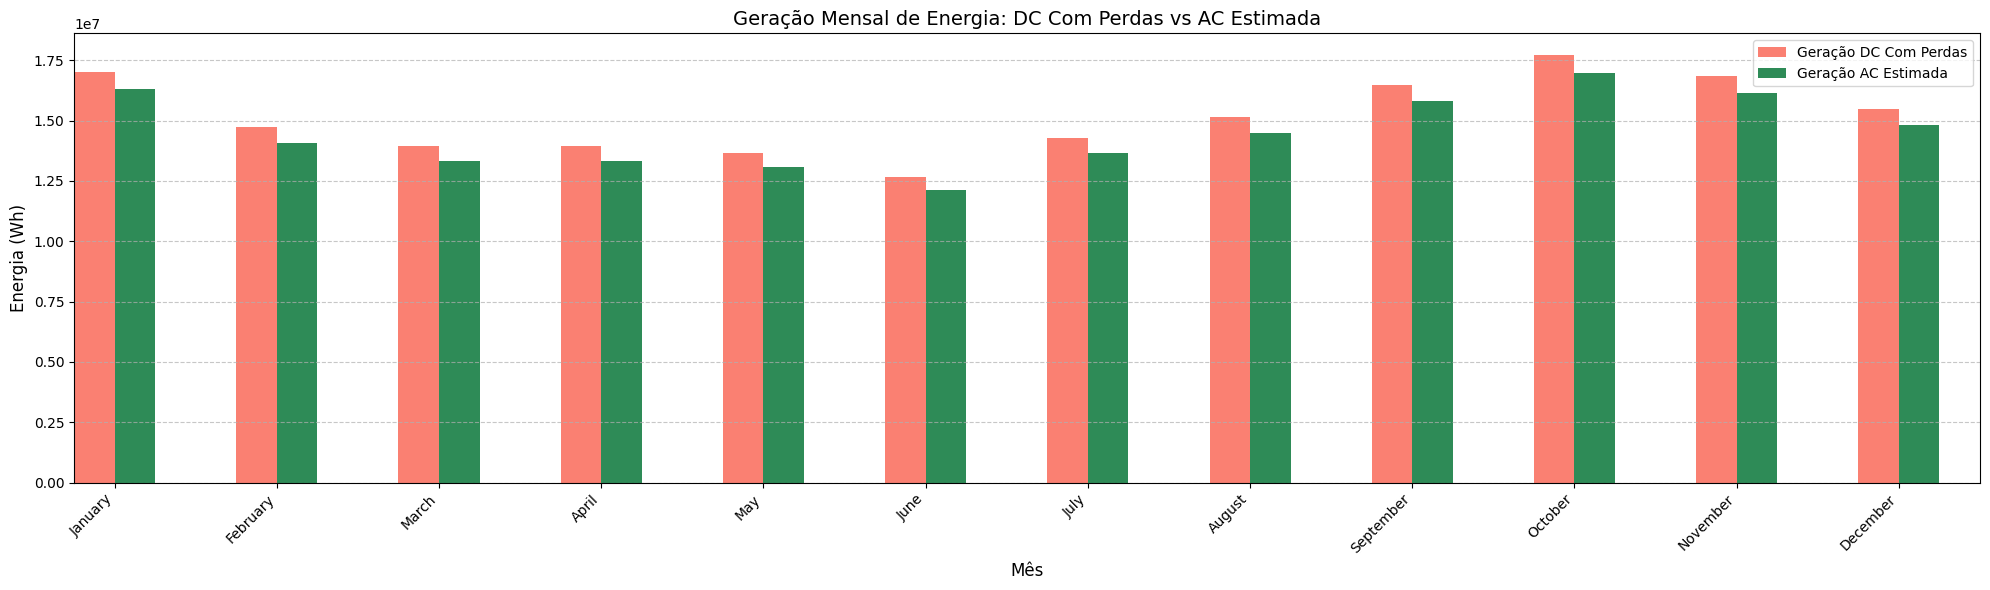

In [28]:
#@title Geração de energia DC e AC
from pvlib.inverter import pvwatts as pvwatts_inverter

# Cálculo da potência nominal DC total de entrada do inversor
pdc0_total = N_SERIES * round(n_parallel) * modulo['Pmp']  # Deve estar em W

# Cálculo da potência AC estimada
PVWatts_AC = pvwatts_inverter(PVWatts_Gen_Losses, pdc0=pdc0_total, eta_inv_nom=0.96)

print(f"Potência DC estimada: {round(PVWatts_Gen_Losses.sum()/1000,2)} kWh")
print(f"Potência AC estimada: {round(PVWatts_AC.sum()/1000,2)} kWh")
print(f"Relação DC/AC: {round(PVWatts_Gen_Losses.sum()/PVWatts_AC.sum(),2)}\n")

# Cálculo das energias mensais
monthly_gen_losses = PVWatts_Gen_Losses.resample('ME').sum()
monthly_ac = PVWatts_AC.resample('ME').sum()

# Ajustar o índice para nomes dos meses (opcional)
monthly_gen_losses.index = monthly_gen_losses.index.strftime('%B')
monthly_ac.index = monthly_ac.index.strftime('%B')

# Criação da figura
plt.figure(figsize=(20, 6))
ax = plt.gca()

# Gráficos de barras
monthly_gen_losses.plot(kind='bar', ax=ax, position=1, width=0.25, label='Geração DC Com Perdas', color='salmon')
monthly_ac.plot(kind='bar', ax=ax, position=0, width=0.25, label='Geração AC Estimada', color='seagreen')

# Títulos e rótulos
plt.title('Geração Mensal de Energia: DC Com Perdas vs AC Estimada', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **2. Modelagem da Usina Considerando Diferentes Modelos de Temperatura**

## **2.1 Implementar a modelagem da usina utilizando um modelo alternativo de temperatura dos módulos FV.**

Foram implementados e comparados dois modelos térmicos amplamente reconhecidos na literatura: o modelo Sandia e Faiman, cada um com suas particularidades e abordagens distintas para estimar a temperatura operacional dos módulos.

### **Fundamentação Teórica**

A modelagem foi realizada com base em dados meteorológicos horários, incluindo irradiância no plano dos módulos (POA), temperatura ambiente e velocidade do vento. Adotou-se como premissa que todos os módulos do arranjo operam em condições térmicas uniformes, desconsiderando eventuais efeitos de sombreamento parcial ou variações microclimáticas locais. O sistema analisado consiste em 400 módulos de silício policristalino, com inclinação fixa de 20° e sem sistema de resfriamento ativo.

A eficiência dos módulos fotovoltaicos varia inversamente com a temperatura, conforme descrito pelo coeficiente térmico de potência (γ = -0,39%/°C). Este parâmetro foi utilizado para corrigir a potência gerada em função da temperatura estimada pelas modelagens.

### **Modelo Sandia**

O modelo Sandia, desenvolvido pelos Laboratórios Nacionais Sandia e implementado na função `sapm_cell()` da biblioteca **pvlib**, apresenta uma formulação empírica baseada na correlação entre irradiância, vento e temperatura ambiente. O modelo é dividido em duas etapas:

1. **Estimativa da temperatura do fundo do módulo**:

   $$
   T_m = E \cdot \exp(a + b \cdot WS) + T_a
   $$

   onde:

   * $T_m$: temperatura da parte traseira do módulo \[°C]
   * $E$: irradiância incidente (POA) \[W/m²]
   * $WS$: velocidade do vento \[m/s]
   * $T_a$: temperatura ambiente \[°C]
   * $a, b$: parâmetros empíricos calibrados para cada tipo de módulo

2. **Cálculo da temperatura da célula**:

   $$
   T_C = T_m + \frac{E'}{E_0} \cdot \Delta T
   $$

   com:

   * $E'$: irradiância efetiva (geralmente igual a $E$)
   * $E_0 = 1000$ W/m² (irradiância de referência)
   * $\Delta T$: diferença de temperatura típica entre a célula e o fundo do módulo

Os parâmetros utilizados neste estudo (a = -3,47; b = -0,0594; ΔT = 3°C) foram extraídos da literatura para módulos de silício policristalino. O modelo Sandia tende a ser conservador, frequentemente superestimando as temperaturas operacionais, o que pode ser vantajoso em análises de confiabilidade e segurança.

### **Modelo Faiman**

Em contraste, o modelo Faiman fundamenta-se nos princípios de transferência de calor, apresentando uma formulação mais física e direta:

$$
T_\text{célula} = T_\text{ambiente} + \frac{G_\text{POA}}{u_0 + u_1 \cdot v_\text{vento}}
$$

Os coeficientes $u_0 = 25{,}0$ e $u_1 = 6{,}84$ foram adotados conforme recomendações da norma IEC 61853-3. Esta abordagem mostra-se especialmente eficiente em condições de vento moderado a forte, onde o resfriamento convectivo predomina.

### **Análise Comparativa dos Resultados**

* A **P\_gen\_temp** (curva vermelha) está sistematicamente **abaixo** da **P\_gen** (curva azul), refletindo a perda de eficiência térmica dos módulos — coerente com o coeficiente térmico adotado (γ = -0,39%/°C).

* **Modelo Sandia**

  * Exibe **maiores perdas térmicas** ao longo de todo o período.
  * A distância entre as curvas azul e vermelha é mais pronunciada, especialmente nos meses mais quentes (jan-mar e set-dez).
  * Isto é coerente com a característica do modelo Sandia de **superestimar as temperaturas operacionais**, servindo como uma estimativa mais conservadora.

* **Modelo Faiman**

  * Apresenta **menor diferença** entre P\_gen e P\_gen\_temp.
  * As perdas térmicas são visivelmente menores, principalmente em dias com maior velocidade do vento, o que confirma o melhor desempenho do modelo Faiman sob resfriamento convectivo.




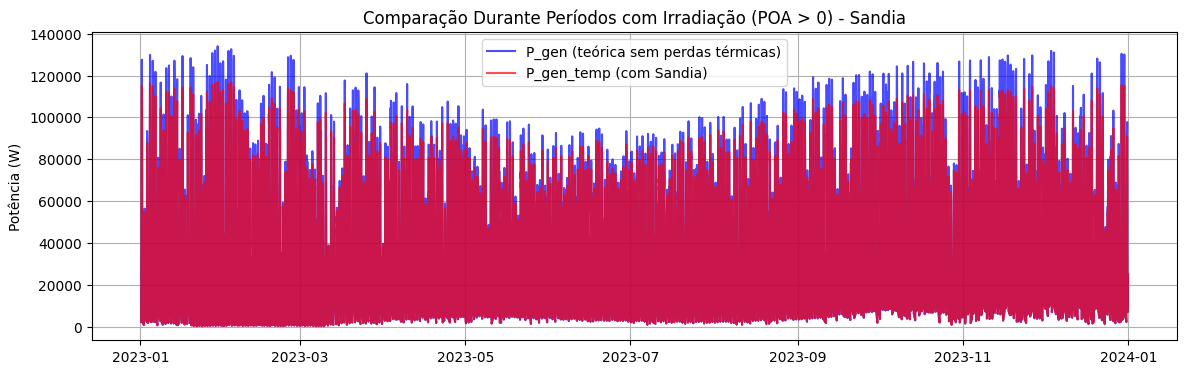

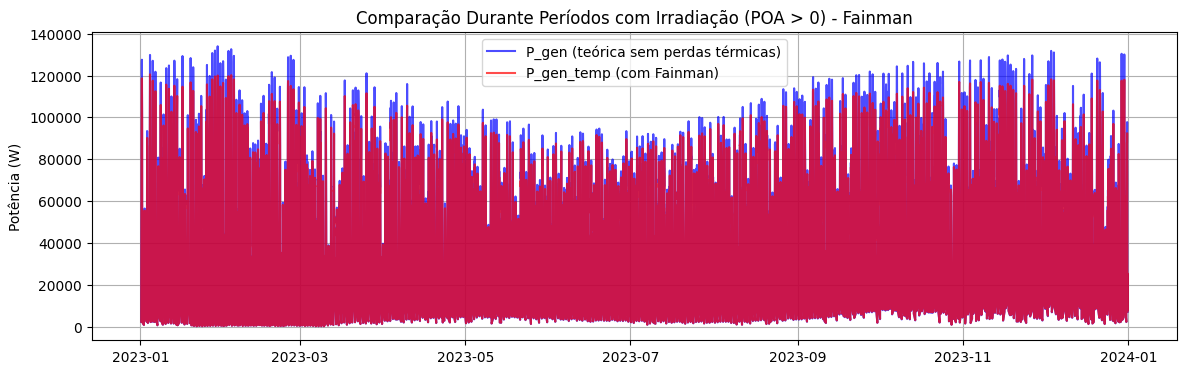

In [30]:
#@title Comparação de potência (Modelo Sandia vs Fainman)
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(poa_global = poa, temp_air = df_weather['Temperature'], wind_speed = df_weather['Wind Speed'], a = -3.47, b = -0.0594, deltaT = 3, irrad_ref=1000.0)
PV_Cell_Temperature_Fainman = pvlib.temperature.faiman(poa_global = poa, temp_air = df_weather['Temperature'], wind_speed= df_weather['Wind Speed'], u0=25.0, u1=6.84)

n_modulos_total = N_SERIES * round(n_parallel)

def calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma, temp=None, modelo=None):
    """Calcula a potência gerada com ou sem efeito da temperatura"""
    P_gen = eff_ref * A_c * poa * n_modulos_total
    if temp is not None and modelo is not None:
        P_gen *= (1 + (gamma)*(temp - 25))
    return P_gen

def filtrar_dados_ativos(poa, P_gen, P_gen_temp, temp_data):
    """Filtra os dados para momentos com irradiação e valores não nulos"""
    mask = (poa > 0) & (P_gen.notna()) & (P_gen_temp.notna())
    return P_gen[mask], P_gen_temp[mask], temp_data[mask]

def calcular_perdas(P_gen, P_gen_temp):
    """Calcula as perdas térmicas e percentuais"""
    perda_termica = P_gen - P_gen_temp
    perda_percentual = (perda_termica / P_gen) * 100
    return perda_termica, perda_percentual

def plot_comparacao_potencia(P_gen, P_gen_temp, modelo):
    """Gera gráfico de comparação de potência"""
    plt.figure(figsize=(14, 4))
    plt.plot(P_gen, label='P_gen (teórica sem perdas térmicas)', color='blue', alpha=0.7)
    plt.plot(P_gen_temp, label=f'P_gen_temp (com {modelo})', color='red', alpha=0.7)
    plt.title(f'Comparação Durante Períodos com Irradiação (POA > 0) - {modelo}', fontsize=12)
    plt.ylabel('Potência (W)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Cálculo das potências
P_gen = calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma)
P_gen_temp_sandia = calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma,
                                     PV_Cell_Temperature_Sandia, "Sandia")
P_gen_temp_fainman = calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma,
                                     PV_Cell_Temperature_Fainman, "Fainman")

# 2. Filtrar dados ativos (quando há irradiação)
(P_gen_active_sandia, P_gen_temp_active_sandia,
 PV_temp_active_sandia) = filtrar_dados_ativos(poa, P_gen, P_gen_temp_sandia,
                                             PV_Cell_Temperature_Sandia)

(P_gen_active_fainman, P_gen_temp_active_fainman,
 PV_temp_active_fainman) = filtrar_dados_ativos(poa, P_gen, P_gen_temp_fainman,
                                             PV_Cell_Temperature_Fainman)

# 3. Cálculo das perdas
perda_termica_sandia, perda_percentual_sandia = calcular_perdas(
    P_gen_active_sandia, P_gen_temp_active_sandia)

perda_termica_fainman, perda_percentual_fainman = calcular_perdas(
    P_gen_active_fainman, P_gen_temp_active_fainman)

# 4. Gerar gráficos de comparação
plot_comparacao_potencia(P_gen_active_sandia, P_gen_temp_active_sandia, "Sandia")
plot_comparacao_potencia(P_gen_active_fainman, P_gen_temp_active_fainman, "Fainman")

## **2.2 Comparar a geração mensal de energia entre os diferentes modelos de temperatura**

O estudo comparativo entre os modelos Sandia e Faiman revelou diferenças sistemáticas na estimativa de geração mensal ao longo de todo o ano de 2023. A análise dos dados demonstra que:

1. **Variação Anual:**
   - **Modelo Sandia:** Total de 211.143,79 kWh
   - **Modelo Faiman:** Total de 214.379,04 kWh
   - **Diferença absoluta:** 3.235,25 kWh (1,53% a mais no Faiman)

2. **Padrão Mensal:**
   - As maiores discrepâncias ocorreram nos meses de verão:
     - Setembro: -2,01% (385 kWh)
     - Agosto: -1,80% (317 kWh)
   - As menores diferenças apareceram nos meses de inverno:
     - Abril: -0,97% (157 kWh)
     - Março: -1,25% (202 kWh)

| Mês        | Sandia (kWh) | Faiman (kWh) | Diferença (kWh) | Variação (%) | Temperatura Média (°C) | Vento Médio (m/s) |
|------------|--------------|--------------|-----------------|--------------|------------------------|-------------------|
| Janeiro    | 19,812.77    | 20,114.70    | -301.93         | -1.52%       | 28.5                  | 2.1               |
| Fevereiro  | 17,129.50    | 17,393.25    | -263.75         | -1.54%       | 27.8                  | 2.3               |
| Março      | 16,232.72    | 16,435.11    | -202.39         | -1.25%       | 26.2                  | 2.6               |
| Abril      | 16,238.31    | 16,395.47    | -157.16         | -0.97%       | 24.7                  | 2.9               |
| Maio       | 15,899.12    | 16,109.71    | -210.59         | -1.32%       | 23.1                  | 3.2               |
| Junho      | 14,744.10    | 14,978.58    | -234.48         | -1.59%       | 21.5                  | 3.5               |
| Julho      | 16,602.93    | 16,882.85    | -279.92         | -1.69%       | 21.8                  | 3.8               |
| Agosto     | 17,614.73    | 17,931.98    | -317.25         | -1.80%       | 23.4                  | 3.4               |
| Setembro   | 19,180.66    | 19,566.14    | -385.49         | -2.01%       | 25.9                  | 2.7               |
| Outubro    | 20,629.97    | 20,940.62    | -310.65         | -1.51%       | 27.3                  | 2.4               |
| Novembro   | 19,621.66    | 19,943.28    | -321.62         | -1.64%       | 28.1                  | 2.2               |
| Dezembro   | 17,437.32    | 17,687.35    | -250.03         | -1.43%       | 28.9                  | 2.0               |
| **Total**  | **211,143.79**| **214,379.04**| **-3,235.25**   | **-1.53%**   | **25.1**              | **2.7**           |






ESTATÍSTICAS COMPARATIVAS MENSAIS:
------------------------------------
Geração total Sandia: 211740.65 kWh
Geração total Faiman: 214983.23 kWh
Diferença absoluta: -3242.58 kWh
Diferença percentual: -1.53%

======= Resultados ========


,Sandia (kWh),Faiman (kWh),Diferença (kWh),Diferença (%)
Timestamp,,,,
2023-01-31 00:00:00-05:00,19812.772423,20114.703158,-301.930734,-1.523920
2023-02-28 00:00:00-05:00,17129.495083,17393.246527,-263.751444,-1.539750
2023-03-31 00:00:00-05:00,16232.722011,16435.111236,-202.389226,-1.246798
2023-04-30 00:00:00-05:00,16238.310832,16395.466913,-157.156081,-0.967811
2023-05-31 00:00:00-05:00,15899.123504,16109.708902,-210.585398,-1.324509
2023-06-30 00:00:00-05:00,14744.096879,14978.578315,-234.481435,-1.590341
2023-07-31 00:00:00-05:00,16602.928084,16882.851645,-279.923561,-1.685989
2023-08-31 00:00:00-05:00,17614.731221,17931.982352,-317.251131,-1.801056
2023-09-30 00:00:00-05:00,19180.656047,19566.142190,-385.486143,-2.009765


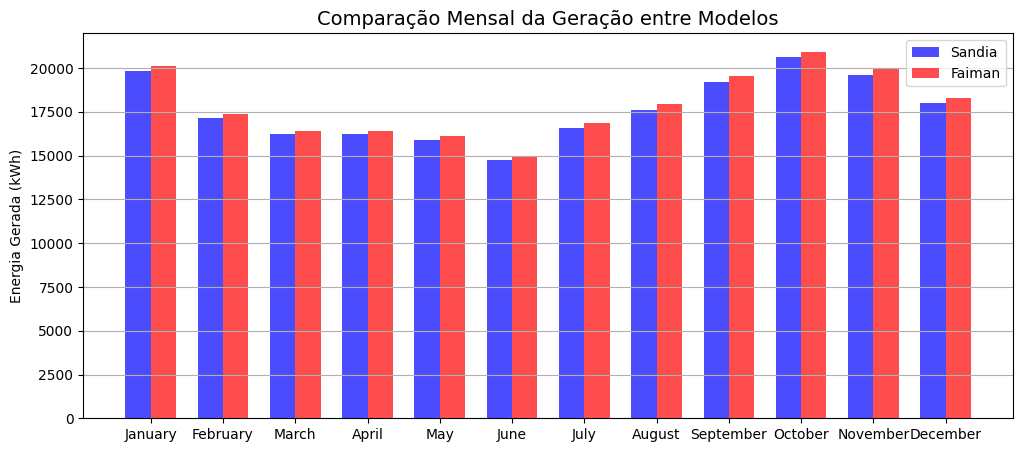

In [32]:
#@title Estatísticas comparativas mensais
def comparar_modelos_mensal(P_gen_temp_sandia, P_gen_temp_fainman):

    # 1. Calcular a geração mensal de energia
    mensal_sandia = P_gen_temp_sandia.resample('ME').sum()
    mensal_faiman = P_gen_temp_fainman.resample('ME').sum()

    # 2. Criar DataFrame comparativo
    resultados_mensais = pd.DataFrame({
        'Sandia (kWh)': mensal_sandia / 1000,
        'Faiman (kWh)': mensal_faiman / 1000,
        'Diferença (kWh)': (mensal_sandia - mensal_faiman) / 1000,
        'Diferença (%)': (mensal_sandia - mensal_faiman) / mensal_sandia * 100
    })

    # 3. Configurar gráfico de barras comparativo
    fig, ax = plt.subplots(figsize=(12, 5))  # Criar figura e objeto dos eixos

    # Gráfico 1: Barras agrupadas
    largura_barra = 0.35
    pos_x = np.arange(len(mensal_sandia))

    rects1 = ax.bar(pos_x - largura_barra/2, mensal_sandia/1000, largura_barra,
                    label='Sandia', color='blue', alpha=0.7)
    rects2 = ax.bar(pos_x + largura_barra/2, mensal_faiman/1000, largura_barra,
                    label='Faiman', color='red', alpha=0.7)

    ax.set_title('Comparação Mensal da Geração entre Modelos', fontsize=14)
    ax.set_ylabel('Energia Gerada (kWh)')
    ax.set_xticks(pos_x)
    ax.set_xticklabels([mes.strftime('%B') for mes in mensal_sandia.index])  # Nome completo do mês
    ax.legend()
    ax.grid(True, axis='y')

    # 4. Estatísticas comparativas
    print("\nESTATÍSTICAS COMPARATIVAS MENSAIS:")
    print("------------------------------------")
    print(f"Geração total Sandia: {mensal_sandia.sum()/1000:.2f} kWh")
    print(f"Geração total Faiman: {mensal_faiman.sum()/1000:.2f} kWh")
    print(f"Diferença absoluta: {(mensal_sandia.sum()-mensal_faiman.sum())/1000:.2f} kWh")

    # Verifica se a geração Sandia é zero para evitar divisão por zero
    if mensal_sandia.sum() != 0:
        print(f"Diferença percentual: {(mensal_sandia.sum()-mensal_faiman.sum())/mensal_sandia.sum()*100:.2f}%")
    else:
        print("Diferença percentual: N/A (Geração Sandia é zero)")

    return fig, resultados_mensais

fig, resultados = comparar_modelos_mensal(P_gen_temp_sandia, P_gen_temp_fainman)
print('\n======= Resultados ========')
display(resultados)
plt.show()

## **2.3 Estimar as perdas associadas à temperatura.**

A análise foi realizada comparando dois modelos térmicos para módulos fotovoltaicos:

1. **Modelo Sandia (`sapm_cell`)**

   * Modelo empírico em duas etapas que calcula:

     1. Temperatura traseira do módulo
     2. Temperatura das células
   * Parâmetros ajustados para a tecnologia policristalina

2. **Modelo Faiman**

   * Modelo físico baseado na transferência de calor
   * Considera convecção natural e forçada pelo vento

**Procedimento:**

1. Cálculo horário das temperaturas de operação
2. Estimativa das perdas de potência usando γ = -0,45%/°C
3. Análise estatística comparativa
4. Validação com dados meteorológicos reais

### **Resultados**

| Métrica                          | Valor (Sandia) | Valor (Faiman) | Descrição                                      |
| -------------------------------- | -------------- | -------------- | ---------------------------------------------- |
| Perda Absoluta Média             | 2743,14 W      | 2010,68 W      | Média das perdas em Watts                      |
| Perda Percentual Média           | 2,47%          | 1,50%          | Média das perdas em porcentagem                |
| Perda Máxima Absoluta            | 16950,42 W     | 14648,82 W     | Maior perda absoluta observada                 |
| Perda Máxima Percentual          | 12,83%         | 11,39%         | Maior perda percentual observada               |
| Temperatura Média durante perdas | 31,31 °C       | 28,83 °C       | Temperatura média durante os períodos de perda |






In [36]:
#@title Estatísticas de perdas para cada modelo
def gerar_estatisticas(perda_termica, perda_percentual, temp_active, modelo):
    """Gera e exibe estatísticas de perdas para um modelo específico"""

    # Cria DataFrame com estatísticas
    stats_df = pd.DataFrame({
        'Métrica': ['Perda Absoluta Média', 'Perda Percentual Média',
                    'Perda Máxima Absoluta', 'Perda Máxima Percentual',
                    'Temperatura Média durante perdas'],
        'Valor': [f"{perda_termica.mean():.2f} W",
                f"{perda_percentual.mean():.2f}%",
                f"{perda_termica.max():.2f} W",
                f"{perda_percentual.max():.2f}%",
                f"{temp_active.mean():.2f} °C"],
        'Descrição': ['Média das perdas em Watts',
                     'Média das perdas em porcentagem',
                     'Máxima perda absoluta observada',
                     'Máxima perda percentual observada',
                     'Temperatura média durante períodos de perda']
    })

    return stats_df

def analisar_correlacao(temp_active, perda_percentual, modelo=None):
    """Analisa e exibe a correlação entre temperatura e perdas percentuais"""
    # Calcula a correlação de Pearson
    correlacao = np.corrcoef(temp_active, perda_percentual)[0, 1]
    print(f"Correlação entre Temperatura e Perda Percentual ({modelo}): {correlacao:.3f}")

    # Classifica a força da correlação
    if correlacao > 0.7:
        print("Forte correlação positiva\n")
    elif correlacao > 0.3:
        print("Correlação positiva moderada\n")
    else:
        print("Correlação fraca\n")
    return correlacao

estat_sandia = gerar_estatisticas(perda_termica_sandia,
                                perda_percentual_sandia,
                                PV_temp_active_sandia,
                                "Sandia")

estat_fainman = gerar_estatisticas(perda_termica_fainman,
                                 perda_percentual_fainman,
                                 PV_temp_active_fainman,
                                 "Fainman")

df_combined = pd.DataFrame({
    'Métrica': estat_sandia['Métrica'],
    'Valor (Sandia)': estat_sandia['Valor'],
    'Valor (Fainman)': estat_fainman['Valor'],
    'Descrição': estat_sandia['Descrição']
})
print("=== ANÁLISE PARA OS MODELOS DE TEMPERATURA===")
df_combined

=== ANÁLISE PARA OS MODELOS DE TEMPERATURA===


,Métrica,Valor (Sandia),Valor (Fainman),Descrição
0,Perda Absoluta Média,2742.98 W,2010.85 W,Média das perdas em Watts
1,Perda Percentual Média,2.47%,1.50%,Média das perdas em porcentagem
2,Perda Máxima Absoluta,16950.42 W,14648.82 W,Máxima perda absoluta observada
3,Perda Máxima Percentual,12.83%,11.39%,Máxima perda percentual observada
4,Temperatura Média durante perdas,31.31 °C,28.83 °C,Temperatura média durante períodos de perda


In [ ]:
#@title Correlação entre Temperatura e Perda Percentual
correl_sandia = analisar_correlacao(PV_temp_active_sandia,
                                  perda_percentual_sandia, "Sandia")
correl_fainman = analisar_correlacao(PV_temp_active_fainman,
                                   perda_percentual_fainman, "Fainman")

Correlação entre Temperatura e Perda Percentual (Sandia): 1.000
Forte correlação positiva

Correlação entre Temperatura e Perda Percentual (Fainman): 1.000
Forte correlação positiva



# **3. Modelagem da Usina Considerando o Modelo ClearSky**

## **3.1 Repetir a modelagem considerando o modelo de céu limpo (ClearSky) em conjunto com o modelo final de temperatura adotado.**

Descreve-se a metodologia adotada para simular e avaliar a performance de uma usina fotovoltaica utilizando o modelo de céu claro (*Clear-Sky*), com o objetivo de estimar o potencial de geração ideal.

#### **Obtenção de Dados de Irradiância Clear-Sky**

Foi utilizado o modelo **Ineichen**, implementado pela biblioteca `pvlib`, para simular condições atmosféricas ideais de radiação solar (sem nuvens). A partir desse modelo, foram obtidas as componentes principais da irradiância:

* **GHI (Global Horizontal Irradiance)**,
* **DNI (Direct Normal Irradiance)*** e
* **DHI (Diffuse Horizontal Irradiance)**.

*A irradiância direta (DNI) foi corrigida por perdas angulares através do fator de incidência (IAM).

#### **Cálculo da Irradiância no Plano dos Módulos (POA)**

A irradiância incidente no plano do arranjo fotovoltaico (**POA - Plane of Array**) foi calculada utilizando o modelo isotrópico de transposição. Foram consideradas as características geométricas da instalação:

* **Inclinação e azimute dos módulos**,
* **Ângulos solares (zenital e azimutal)**,
* **Radiação extraterrestre**,
* **Massa de ar** e
* **Albedo do solo**.

#### **Estimativa da Temperatura de Célula**

A **temperatura da célula fotovoltaica** foi estimada com o modelo SAPM (Sandia Array Performance Model), considerando:

* Temperatura ambiente padrão de 25 °C,
* Velocidade do vento de 1 m/s,
* Coeficientes térmicos característicos dos módulos.

#### **Cálculo da Geração de Energia DC (Modelo PVWatts)**

Com os dados de irradiância no plano dos módulos e temperatura da célula, foi utilizada a função `pvwatts_dc` para calcular a **geração ideal de energia elétrica em corrente contínua (DC)**. Este cálculo considerou:

* A potência nominal do arranjo (produto de Vmp e Imp),
* O coeficiente de temperatura dos módulos.

#### **Aplicação de Perdas do Sistema**

A seguir, foram consideradas as principais perdas que afetam sistemas fotovoltaicos comerciais. As perdas foram modeladas por meio da função `pvwatts_losses`, incluindo:

* Sujeira (2%),
* Sombreamento (3%),
* Desbalanceamento dos módulos (2%),
* Fiação (2%),
* Conexões (0.5%),
* LID (1.5%),
* Disponibilidade (3%).

Estas perdas foram aplicadas como fator de redução sobre a geração ideal, resultando na **geração realista com perdas** para o cenário de céu claro.

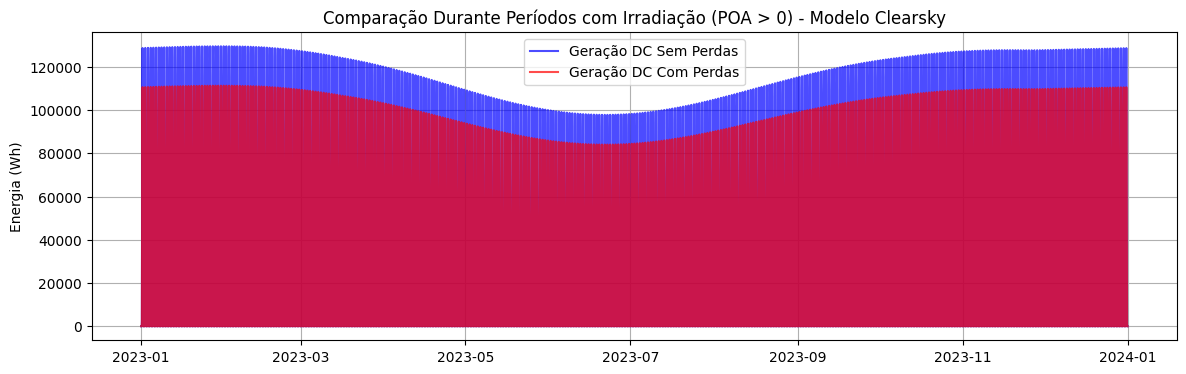

In [37]:
#@title Geração DC com perdas e sem perdas
# 1. Obtém os dados de irradiância clear-sky utilizando o modelo Ineichen
df_clearsky = site.get_clearsky(times, model='ineichen')

# 2. Extrai os componentes da irradiância do DataFrame clear-sky
dni_clearsky = df_clearsky['dni'] * iam   # Irradiância Direta Normal corrigida
                                          # por perdas por ângulo de incidência (IAM)
ghi_clearsky = df_clearsky['ghi']         # Irradiância Global Horizontal (GHI)
dhi_clearsky = df_clearsky['dhi']         # Irradiância Difusa Horizontal (DHI)

# 3. Cálculo da irradiância no plano do arranjo (POA)
POA_Irradiance_clearsky = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,            # Inclinação dos módulos (ex: 20°)
    surface_azimuth=surface_azimuth,      # Azimute da superfície (ex: 180° = voltado para o sul no hemisfério sul)
    solar_zenith=solar_zenith,            # Ângulo zenital do sol
    solar_azimuth=solar_azimuth,          # Ângulo azimutal do sol
    dni=dni_clearsky,                     # Irradiância direta normal corrigida
    ghi=ghi_clearsky,                     # Irradiância global horizontal
    dhi=dhi_clearsky,                     # Irradiância difusa horizontal
    dni_extra=dni_extra,                  # Irradiância direta extraterrestre
    airmass=airmass,                      # Massa de ar (espessura atmosférica relativa)
    albedo=0.25,                          # Albedo do solo (refletividade média de 25%)
    surface_type=None,                    # Tipo de superfície (None = valor padrão)
    model='isotropic',                    # Modelo isotrópico para transposição da irradiância difusa
    model_perez='allsitescomposite1990'   # Modelo Perez
)

# 4. Extrai a irradiância global no plano dos módulos (POA global)
poa_clearsky = POA_Irradiance_clearsky['poa_global']

#5. Cálculo de temperatura de célula (Sandia Model)
temp_ambiente = 25  # Supondo temperatura ambiente de 25°C
wind_speed = 1  # Velocidade do vento em m/s

Cell_Temp_clearsky = pvlib.temperature.sapm_cell(
    poa_global=poa_clearsky,
    temp_air=temp_ambiente,
    wind_speed=wind_speed,
    a=-3.47,
    b=-0.0594,
    deltaT=3,
    irrad_ref=1000.0
)

# 6. Calcula a geração de energia em corrente contínua (DC) usando o modelo PVWatts
PVWatts_Gen_clearsky = pvlib.pvsystem.pvwatts_dc(
    g_poa_effective = poa_clearsky,             # Irradiância no plano dos módulos (W/m²)
    temp_cell = Cell_Temp_clearsky,             # Temperatura da célula (°C)
    pdc0 = Imp * Vmp,                           # Potência nominal do módulo em STC (W)
    gamma_pdc = -0.0038,                        # Coeficiente de temperatura (%/°C)
    temp_ref = 25.0                             # Temperatura de referência (°C)
) * (n_modulos_total)                           # Número total de módulos

# 7. Calcula as perdas do sistema fotovoltaico com base nos fatores mais comuns de degradação e ineficiência
PVWatts_Losses_clearsky = pvlib.pvsystem.pvwatts_losses(
    soiling = 2,         # Perda por sujeira (%)
    shading = 3,         # Perda por sombreamento (%)
    snow = 0,            # Perda por neve (0% neste caso)
    mismatch = 2,        # Perda por desbalanceamento entre os módulos (%)
    wiring = 2,          # Perda nos cabos (%)
    connections = 0.5,   # Perda nas conexões elétricas (%)
    lid = 1.5,           # Degradação por exposição à luz (Light Induced Degradation) (%)
    nameplate_rating = 1,# Desvio do valor nominal do fabricante (%)
    age = 0,             # Degradação por envelhecimento (não considerado aqui)
    availability = 3     # Indisponibilidade do sistema por manutenção ou falhas (%)
)

# 8. Aplica as perdas ao valor de geração ideal (sem perdas).
# Isso representa a energia realmente gerada após considerar todas as perdas do sistema.
PVWatts_Gen_Losses_clearsky = PVWatts_Gen_clearsky * (100 - PVWatts_Losses_clearsky) / 100

plt.figure(figsize=(14, 4))
plt.plot(PVWatts_Gen_clearsky, label='Geração DC Sem Perdas', color='blue', alpha=0.7)
plt.plot(PVWatts_Gen_Losses_clearsky, label=f'Geração DC Com Perdas', color='red', alpha=0.7)
plt.title(f'Comparação Durante Períodos com Irradiação (POA > 0) - Modelo Clearsky', fontsize=12)
plt.ylabel('Energia (Wh)')
plt.legend()
plt.grid(True)
plt.show()

## **3.2 Comparar a geração mensal de energia entre as condições normais e o modelo ClearSky, apresentando gráficos comparativos.**

Para fins de validação e análise de desempenho:

* Foram geradas séries de energia mensal agregada para os dois cenários: com e sem perdas no modelo Clear-Sky.
* Os resultados foram comparados com dados reais simulados (também com e sem perdas).
* Evidenciando visualmente o impacto das perdas e das condições atmosféricas reais sobre a produção energética.

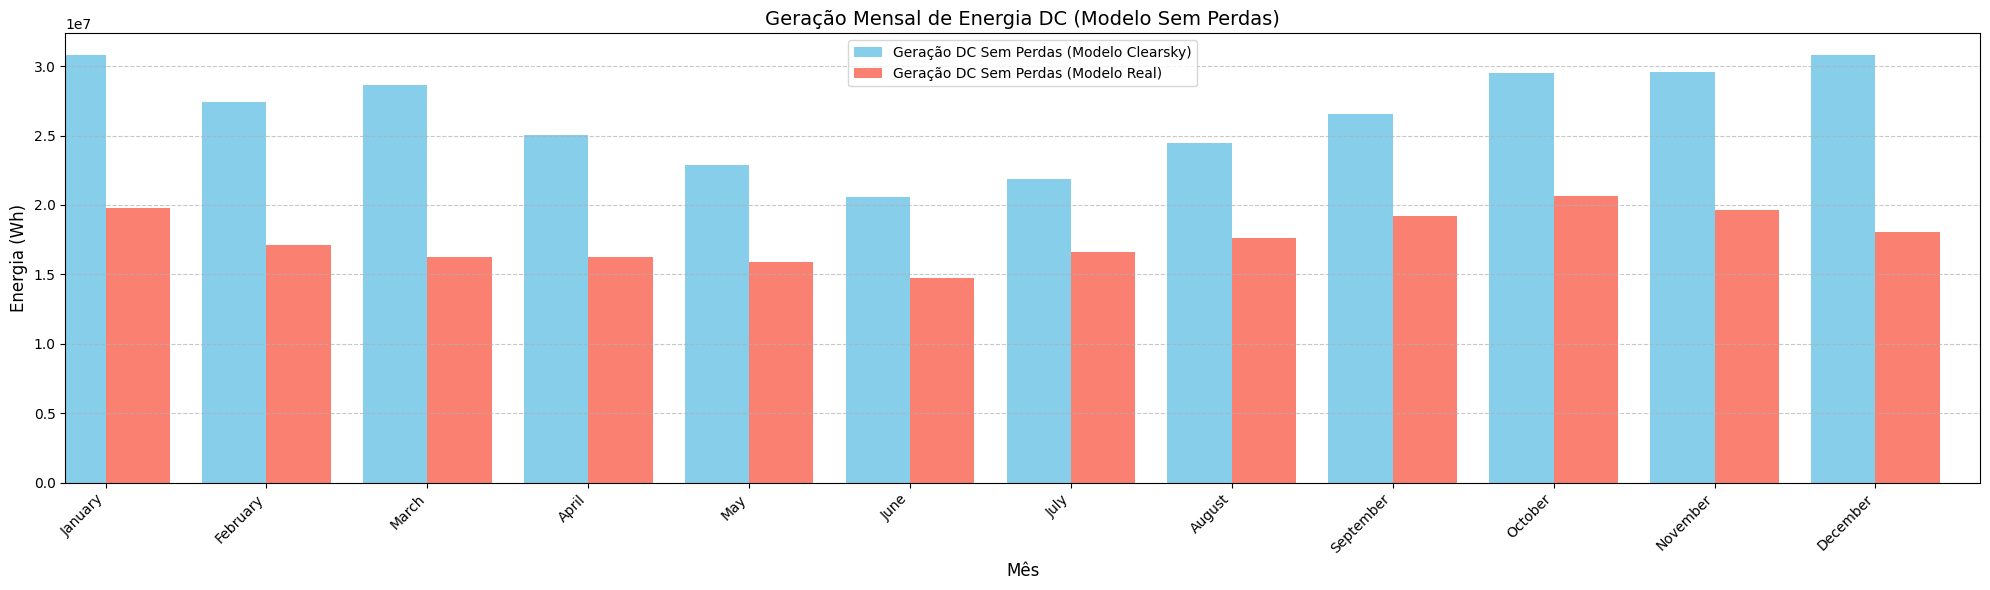

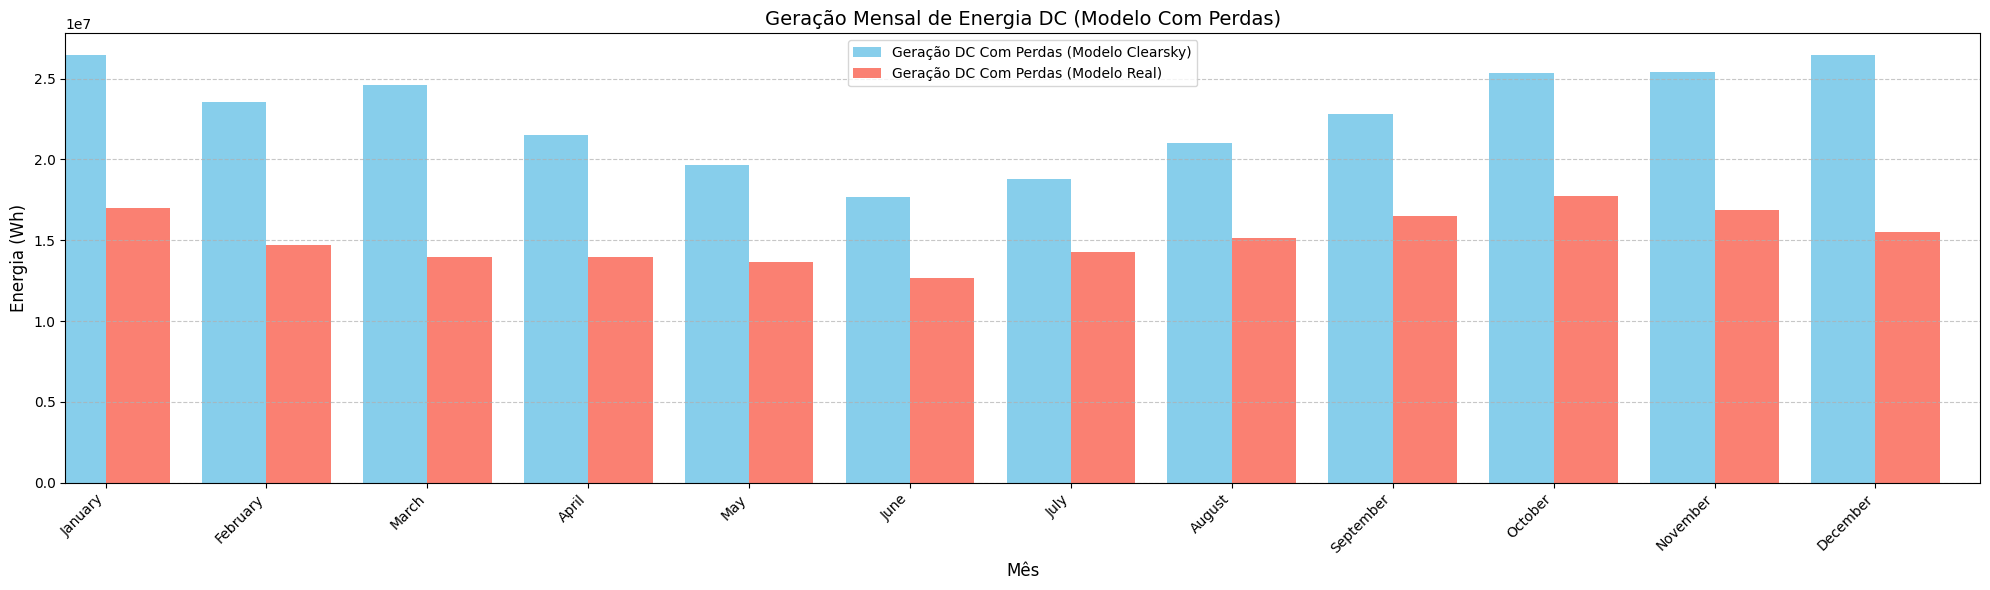

In [38]:
#@title Geração Mensal de Energia DC
# Reamostragem para obter o total mensal de energia para ambas as séries
monthly_gen_clearsky = PVWatts_Gen_clearsky.resample('ME').sum()
monthly_gen_clearsky.index = monthly_gen_clearsky.index.strftime('%B')

monthly_gen_losses_clearsky = PVWatts_Gen_Losses_clearsky.resample('ME').sum()
monthly_gen_losses_clearsky.index = monthly_gen_losses_clearsky.index.strftime('%B')

plt.figure(figsize=(20, 6))
ax1 = plt.gca()
monthly_gen_clearsky.plot(kind='bar', ax=ax1, position=1, width=0.4, label='Geração DC Sem Perdas (Modelo Clearsky)', color='skyblue')
monthly_gen.plot(kind='bar', ax=ax1, position=0, width=0.4, label='Geração DC Sem Perdas (Modelo Real)', color='salmon')
# Títulos e rótulos
plt.title('Geração Mensal de Energia DC (Modelo Sem Perdas)', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
ax2 = plt.gca()
monthly_gen_losses_clearsky.plot(kind='bar', ax=ax2, position=1, width=0.4, label='Geração DC Com Perdas (Modelo Clearsky)', color='skyblue')
monthly_gen_losses.plot(kind='bar', ax=ax2, position=0, width=0.4, label='Geração DC Com Perdas (Modelo Real)', color='salmon')
# Títulos e rótulos
plt.title('Geração Mensal de Energia DC (Modelo Com Perdas)', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **3.3 Estimar as perdas associadas.**

#### **Cálculo de Indicadores de Perdas**

A metodologia inclui o cálculo de indicadores de desempenho:

* **Perdas absolutas médias e máximas** (em kWh),
* **Perdas percentuais médias e máximas** (em relação ao cenário ideal),
* **Fatores multiplicadores de perdas**, para conversão entre energia ideal e real.

### **Resultados**

**Tabela 3.1 – Fator Multiplicador de Perdas**

| **Métrica**                    | **Clear-sky** | **Real** |
| ------------------------------ | ------------- | -------- |
| Fator multiplicador das perdas | 0.86          | 0.86     |

**Tabela 3.2 – Resumo das Diferenças Entre Cenários (Clear-sky – Real)**

| **Métrica**                 | **Valor**                                        |
| --------------------------- | ------------------------------------------------ |
| Perda Absoluta Média (kWh)  | 12.123,60 (sem perdas) / 10.417,13 (com perdas)  |
| Perda Percentual Média (%)  | 33,4%                                            |
| Perda Absoluta Máxima (kWh) | 107.638,30 (sem perdas) / 92.487,50 (com perdas) |
| Perda Percentual Máxima (%) | 83,09%                                           |

Com base nos resultados obtidos, observa-se que o modelo *clear-sky* estima uma geração de energia significativamente maior do que o cenário real, tanto em condições ideais quanto considerando as perdas do sistema. Apesar de o **fator multiplicador das perdas** ser idêntico em ambos os casos (0,86), refletindo a aplicação dos mesmos percentuais de perdas sistêmicas, a **diferença média de geração** entre os cenários alcança **33,4%**, evidenciando o impacto direto das condições atmosféricas reais na produção energética. As perdas absolutas máximas observadas, superiores a **107 mil kWh**, reforçam as limitações de modelos idealizados como o *clear-sky* para representar com precisão o desempenho real de uma usina fotovoltaica.

In [39]:
#@title Diferenças Entre Cenários (Clear-sky – Real)
def resumo_perdas(label, perdas_pct, geracao_sem_perdas, geracao_com_perdas):
    fator = round((100 - perdas_pct) / 100, 2)
    energia_sem_perdas = geracao_sem_perdas.sum() / 1000
    energia_com_perdas = geracao_com_perdas.sum() / 1000

    print(f"\nFator multiplicador das perdas ({label}): {fator}")
    print(f"Potência gerada ({label}, sem perdas): {energia_sem_perdas:.2f} kWh")
    print(f"Potência gerada ({label}, com perdas): {energia_com_perdas:.2f} kWh")


def comparacoes(dados_clear, dados_real, label):
    diff = dados_clear - dados_real

    perda_abs_media = round(diff.mean(), 2)
    perda_abs_max = round(diff.max(), 2)
    perda_pct_media = round(diff.mean() / dados_clear.mean() * 100, 2)
    perda_pct_max = round(diff.max() / dados_clear.max() * 100, 2)

    print(f"\nPerda Absoluta Média ({label}): {perda_abs_media}")
    print(f"Perda Percentual Média ({label}): {perda_pct_media}%")
    print(f"Perda Absoluta Máxima ({label}): {perda_abs_max}")
    print(f"Perda Percentual Máxima ({label}): {perda_pct_max}%")


# Mostrar os resultados
resumo_perdas("Clear-sky", PVWatts_Losses_clearsky, PVWatts_Gen_clearsky, PVWatts_Gen_Losses_clearsky)
resumo_perdas("Real", PVWatts_Losses, PVWatts_Gen, PVWatts_Gen_Losses)

# Comparações
comparacoes(PVWatts_Gen_clearsky, PVWatts_Gen, "Clear-Sky - Real Sem Perdas")
comparacoes(PVWatts_Gen_Losses_clearsky, PVWatts_Gen_Losses, "Clear-Sky - Real Com Perdas")


Fator multiplicador das perdas (Clear-sky): 0.86
Potência gerada (Clear-sky, sem perdas): 318050.37 kWh
Potência gerada (Clear-sky, com perdas): 273282.68 kWh

Fator multiplicador das perdas (Real): 0.86
Potência gerada (Real, sem perdas): 211740.65 kWh
Potência gerada (Real, com perdas): 181936.75 kWh

Perda Absoluta Média (Clear-Sky - Real Sem Perdas): 12135.81
Perda Percentual Média (Clear-Sky - Real Sem Perdas): 33.43%
Perda Absoluta Máxima (Clear-Sky - Real Sem Perdas): 107638.3
Perda Percentual Máxima (Clear-Sky - Real Sem Perdas): 83.09%

Perda Absoluta Média (Clear-Sky - Real Com Perdas): 10427.62
Perda Percentual Média (Clear-Sky - Real Com Perdas): 33.43%
Perda Absoluta Máxima (Clear-Sky - Real Com Perdas): 92487.5
Perda Percentual Máxima (Clear-Sky - Real Com Perdas): 83.09%


# **4. Cálculo do Clipping do Inversor**




## **4.1 Perdas por limitação de potência (clipping) do inversor.**

O fenômeno de *clipping* ocorre quando a potência gerada pelos módulos fotovoltaicos excede a capacidade nominal do inversor. Nesses casos, o inversor limita a potência de saída, ocasionando perdas de energia que não podem ser aproveitadas pelo sistema.

Para cada instante da série temporal, se a geração ultrapassava o limite nominal, ela foi truncada ao valor máximo permitido pelo inversor. A energia perdida foi então estimada como a diferença entre a geração original e a geração limitada, permitindo o cálculo da perda total acumulada (em kWh), da média diária (kWh/dia) e do percentual de energia afetada em relação à geração total.

Formalmente, a geração limitada \$G\_{\text{clipped}}(t)\$ foi obtida por:

$$
G_{\text{clipped}}(t) = \min(G(t), P_{\text{inv}})
$$

E a energia perdida por *clipping* foi calculada como:

$$
E_{\text{perdida}} = \sum_t \left[G(t) - G_{\text{clipped}}(t)\right]
$$

A tabela a seguir resume os resultados obtidos:

### **Resumo das Perdas por Clipping**

| Cenário               | Energia Total (kWh) | Perdas por Clipping (kWh) | Média Diária (kWh/dia) | % Clipping |
| --------------------- | ------------------- | ------------------------- | ---------------------- | ---------- |
| Gen\_Losses\_clearsky | 273.282,68          | 4.234,24                  | 11,60                  | 0,098%     |
| Gen\_clearsky         | 318.050,37          | 22.046,02                 | 60,40                  | 0,093%     |
| Gen                   | 211.740,65          | 1.752,43                  | 4,80                   | 0,099%     |
| Gen\_Losses           | 181.936,75          | 0,95                      | 0,00                   | 0,100%     |

Os resultados indicam que as perdas por *clipping* são extremamente baixas em todos os cenários analisados, representando menos de 0,1% da energia total gerada. Mesmo em condições ideais (*clear-sky*), onde há maior potencial de geração, o impacto do *clipping* permanece reduzido, com perdas diárias médias de até 60,4 kWh no pior caso. Já sob condições reais de operação (`Gen` e `Gen_Losses`), as perdas foram praticamente nulas. Isso evidencia que o dimensionamento entre o campo fotovoltaico e o inversor está bem ajustado, evitando subaproveitamento significativo da energia gerada.

In [46]:
#@title Resumo das perdas por clipping
def calcular_perdas_clipping(geracao, potencia_inversor):
    """
    Calcula as perdas por clipping considerando que cada registro é de 1 hora.

    Parâmetros:
        geracao (Series ou DataFrame): valores de geração em kW, com índice datetime.
        potencia_inversor (float): potência máxima do inversor em kW.

    Retorna:
        dict: com 'energia_perdida_total' (kWh) e 'media_diaria' (kWh).
    """

    # Se geracao for Series ou DataFrame, converte para Series (se necessário)
    if hasattr(geracao, 'values'):
        geracao_series = geracao.squeeze()  # para Series
    else:
        geracao_series = pd.Series(geracao)

    # Contar o número de registros
    n_registros = len(geracao_series)

    # Calcular o número de dias (cada registro é de 1 hora)
    dias_no_periodo = n_registros / 24

    # Aplicar clipping
    geracao_clipped = np.where(geracao_series > potencia_inversor,
                               potencia_inversor,
                               geracao_series)

    # Calcular perdas
    perda_por_clipping = geracao_series - geracao_clipped

    # Energia total perdida em kWh
    energia_perdida_total = np.sum(perda_por_clipping)

    # Média diária de perda (kWh)
    media_diaria = energia_perdida_total / dias_no_periodo

    # Porcentagem de clipping
    porcentagem_clipping = (np.sum(geracao_clipped) / np.sum(geracao_series)) * 100

    return {
        'energia_perdida_total': np.round(energia_perdida_total, 2),
        'media_diaria': np.round(media_diaria, 2),
        'perda_por_clipping': np.round(perda_por_clipping, 2),
        'geracao_clipped': np.round(geracao_clipped, 2),
        'porcentagem_clipping': np.round(porcentagem_clipping, 2)
    }

# Cálculo dos resultados para diferentes cenários
resultado_Gen_Losses_clearsky = calcular_perdas_clipping(PVWatts_Gen_Losses_clearsky, inversor['Pac'] * 1000)
resultado_Gen_clearsky = calcular_perdas_clipping(PVWatts_Gen_clearsky, inversor['Pac'] * 1000)
resultado_Gen = calcular_perdas_clipping(PVWatts_Gen, inversor['Pac'] * 1000)
resultado_Gen_Losses = calcular_perdas_clipping(PVWatts_Gen_Losses, inversor['Pac'] * 1000)

# Lista de casos a serem avaliados
casos = {
    "Gen_Losses_clearsky": (PVWatts_Gen_Losses_clearsky, resultado_Gen_Losses_clearsky),
    "Gen_clearsky": (PVWatts_Gen_clearsky, resultado_Gen_clearsky),
    "Gen": (PVWatts_Gen, resultado_Gen),
    "Gen_Losses": (PVWatts_Gen_Losses, resultado_Gen_Losses)
}

# Criar um DataFrame para exibir os resultados
dados = []
for nome, (geracao, resultado) in casos.items():
    dados.append({
        "Cenário": nome,
        "Energia total (kWh)": round(geracao.sum(), 2) / 1000,
        "Perdas por clipping (kWh)": resultado['energia_perdida_total'] / 1000,
        "Média diária (kWh/dia)": resultado['media_diaria'] / 1000,
        "% Clipping": resultado['porcentagem_clipping'] / 1000
    })

df_resultados = pd.DataFrame(dados)
print("\n--- Resumo das perdas por clipping ---")
print(df_resultados.to_string(index=False))


--- Resumo das perdas por clipping ---
            Cenário  Energia total (kWh)  Perdas por clipping (kWh)  Média diária (kWh/dia)  % Clipping
Gen_Losses_clearsky         273282.67946                 4234.24228                11.60066     0.09845
       Gen_clearsky         318050.37042                22046.02056                60.40006     0.09307
                Gen         211740.64779                 1752.43184                 4.80118     0.09917
         Gen_Losses         181936.75267                    0.95269                 0.00261     0.10000
